In [1]:
%cd /Users/lucas/repositories/degen_discovery/simple_problems/remote_runs/

/Users/lucas/repositories/degen_discovery/simple_problems/remote_runs


/usr/local/Caskroom/miniconda/base/envs/pyoperon/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
pwd

'/Users/lucas/repositories/degen_discovery/simple_problems/remote_runs'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pyoperon.sklearn import SymbolicRegressor
import multiprocessing
import csv
from sklearn.metrics import r2_score
import string
import sys
import sympy
import scipy
import esr.generation.generator

import jax
import jax.numpy as jnp

from tqdm import tqdm as tq


In [4]:
# from postprocessing_utils import load_and_process_data, process_ensemble_rotation

# Import preprocessing (rotations, data loading)
from preprocessing_utils import (
    load_and_process_data,
    process_ensemble_rotation,
    flatten_with_numerical_jacobian,
    batch_flatten_fisher,
    rotate_coords,
    load_and_process_data,
    weighted_std
)

# Import postprocessing (SR optimization)
from postprocessing_utils import (
    lossfn_jac_jax,
    get_component,
    get_pruned_expressions,
    get_pruned_expressions_final,
    check_flattening,
    make_check_flattening_fn,
)

# Create loss function
# _lossfn = lambda a: lossfn_jac_jax(
#     a, all_pars, all_fns, all_linear_pars, all_linear_inds,
#     X=X, Fs=Fs, n_params=n_params, delta=0.2, alpha=1.5
# )

# Option 1: Load and process in one call
data = load_and_process_data(
    datapath="./",
    filename="fake_cmb_flatten_03_09_sum.npz",
    num_samps=4000,
    process_ensemble=True,  # <-- enables full processing
    n_d=1.0,
    verbose=True
)

# Access results directly:
y = data['y']           # Weighted average outputs (masked)
y_std = data['y_std']   # Weighted std (masked)
dy = data['dy']         # Weighted average Jacobian (masked)
dy_sr = data['dy_sr']   # Weighted average rotated Jacobian
Fs = data['Fs']         # Weighted average Fisher
X = data['X']           # Parameters (masked)
rotmat_avg = data['rotmat_avg']  # Average rotation matrix

# Option 2: Two-step process (more control)
# data = load_and_process_data(datapath="./", filename="fake_cmb_flatten_03_09_sum.npz", process_ensemble=False)
# result = process_ensemble_rotation(
#     datafile=data['datafile'],
#     randidx=data['randidx'],
#     Favg=data['Favg'],
#     best_model_idx=data['best_model_idx'],
#     n_d=1.0
# )

best model 9
Network 0: y.min() = -1.461748, weight = 2010753.1
thetastar [0.6315514  0.44120693 0.54719007 0.44854033 0.4729259  0.46151984]
rotmat [[ 0.90581536  0.01617569  0.2336381   0.22018996 -0.2591073   0.09502769]
 [ 0.03972226  0.96119076 -0.01838121 -0.2223722   0.04823855  0.14973381]
 [-0.17495117 -0.07562473  0.90779614 -0.34185302 -0.03446727  0.14672507]
 [-0.12886776  0.2370409   0.26857215  0.39028746 -0.16342148 -0.8222182 ]
 [ 0.10786656  0.03322142  0.19143173  0.38017556  0.89597225  0.05758104]
 [-0.3450667   0.11331099  0.11047558  0.6988177  -0.31603152  0.5173616 ]]
  Shapes: y=(4000, 6), X=(4000, 6)
Network 1: y.min() = -1.786609, weight = 4341425.5
thetastar [0.6315514  0.44120693 0.54719007 0.44854033 0.4729259  0.46151984]
rotmat [[ 0.9378903   0.0802314   0.14968513  0.24940464 -0.1549038  -0.07294901]
 [-0.00423169  0.96896315 -0.04525012 -0.20677367  0.04301338  0.12016685]
 [-0.03831702 -0.04703081  0.93069386 -0.29669285  0.07542543  0.1908212 ]
 [-0

In [6]:
data['dys'].shape

In [7]:
data['eta_ensemble'].shape

In [6]:
alpha = np.random.rand() * 2 * np.pi
R = np.array([[np.cos(alpha), -np.sin(alpha), 0],
                [np.sin(alpha), np.cos(alpha), 0],
                [0, 0, 1]])
# t = np.random.randn(3) * 10

ytest = data['eta_ensemble'][12]




# ytest = ytest[:, _ind]

ytest_rot, *_ = rotate_coords(ytest, X, Fs, data['dys'][12], y_reference=data['eta_ensemble'][0])

# _ind = np.argsort(ytest_rot.var(0))[::-1]
# ytest_rot = ytest_rot[:, _ind]


# now rotate by random vector
R = np.array([[np.cos(alpha), -np.sin(alpha), 0, 0, 0, 0],
                [np.sin(alpha), np.cos(alpha), 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0],
                [0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0, 1]])


from scipy.stats import ortho_group  # Requires version 0.18 of scipy

R = ortho_group.rvs(dim=6)

ytest_p = np.einsum("ij,bj->bi", R, ytest)

ytest_p_rot, *_ = rotate_coords(ytest_p, X, Fs, data["dys"][12],  y_reference= data['eta_ensemble'][0])

# change order of indexes
# _ind = np.argsort(ytest_p_rot.var(0))[::-1]
# ytest_p_rot = ytest_p_rot[:, _ind]






thetastar [0.6315514  0.44120693 0.54719007 0.44854033 0.4729259  0.46151984]
rotmat [[ 0.91185236  0.06497677 -0.25065213 -0.24032246  0.13284445  0.16147512]
 [-0.21372521  0.897947   -0.10990661 -0.31552434  0.01895896  0.1897849 ]
 [ 0.20695084  0.14008805  0.94707775 -0.06498481  0.19051838 -0.0083637 ]
 [ 0.16528937  0.29097834 -0.08140058  0.19477579  0.03729863 -0.9176361 ]
 [-0.16087373 -0.05340433 -0.1465278   0.08059944  0.97094846  0.02366003]
 [ 0.16375954  0.28692204 -0.00640235  0.8910852  -0.03954101  0.3085796 ]]
thetastar [0.6315514  0.44120693 0.54719007 0.44854033 0.4729259  0.46151984]
rotmat [[ 0.5431151   0.36175403  0.5036186  -0.52307534 -0.12509908  0.17683432]
 [ 0.20995593 -0.6245791   0.49472505  0.06074537  0.04982795 -0.5611537 ]
 [-0.44202274 -0.39720303  0.4482482  -0.0535444  -0.11165941  0.65618896]
 [-0.47028428  0.38537878  0.29955158  0.08408892 -0.61964476 -0.38672236]
 [-0.4926344   0.08708134  0.03957071 -0.63010055  0.52869225 -0.26761985]
 [ 0

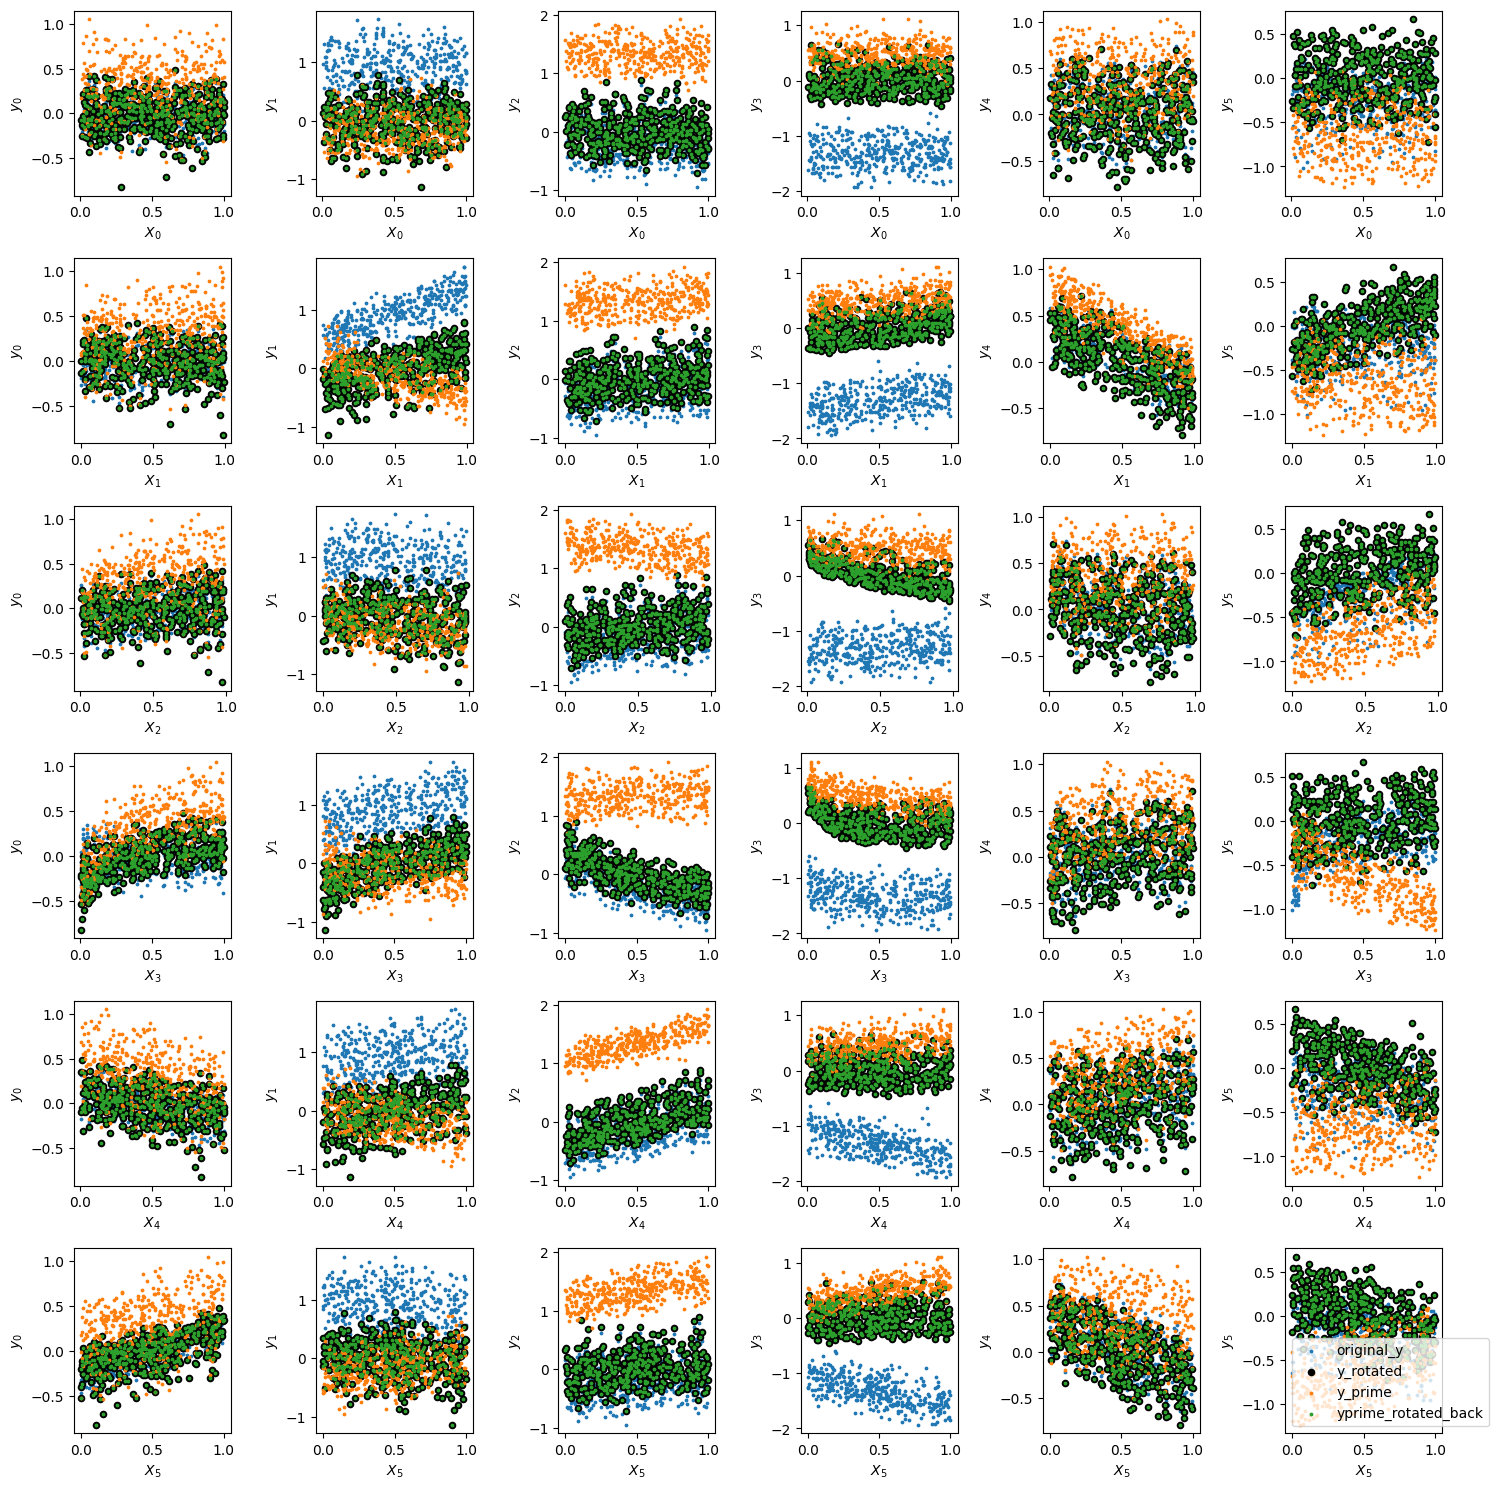

In [7]:

fig, axs = plt.subplots(6, 6, figsize=(15,15))

skip=10

for i in range(X.shape[-1]):
    for j in range(y.shape[-1]):
        
        # row, column
        axs[i,j].scatter(X[::skip,i], ytest[::skip, j], label='original_y', s=3)
        axs[i,j].scatter(X[::skip,i], ytest_rot[::skip, j], label='y_rotated', s=20, c='k')
        axs[i,j].scatter(X[::skip,i], ytest_p[::skip, j], label='y_prime', s=3)
        axs[i,j].scatter(X[::skip,i], ytest_p_rot[::skip, j], label='yprime_rotated_back', s=3)


        axs[i,j].set_xlabel(r"$X_%d$"%(i))
        axs[i,j].set_ylabel(r"$y_%d$"%(j))

plt.legend()
plt.tight_layout()
plt.show()

thetastar [0.6315514  0.44120693 0.54719007 0.44854033 0.4729259  0.46151984]
rotmat [[ 0.9710759  -0.10052076  0.10260394  0.0392343   0.18394385  0.03170216]
 [ 0.05134993  0.8204907   0.08299205 -0.4779104   0.19391012  0.22643077]
 [-0.09887114 -0.08758748  0.96647334  0.0508433  -0.10776012  0.18516177]
 [ 0.07345337  0.44160873  0.16062012  0.3496686  -0.17481309 -0.7880097 ]
 [-0.19512805 -0.01563567  0.0813667   0.30342248  0.9254347  -0.08102596]
 [ 0.03360049  0.33727765 -0.12686454  0.74373627 -0.17309588  0.53470963]]
thetastar [0.6315514  0.44120693 0.54719007 0.44854033 0.4729259  0.46151984]
rotmat [[ 0.9248631  -0.20032704  0.25030786  0.04982428  0.03257805  0.19570225]
 [ 0.10749337  0.79973304  0.13368645 -0.48965257  0.19327551  0.23213239]
 [-0.28494576 -0.08204934  0.925703    0.02488062 -0.20762998  0.10685948]
 [ 0.18880214  0.44784534  0.15618989  0.441322   -0.06517039 -0.7351061 ]
 [-0.11501867 -0.08052945  0.1564494   0.27299023  0.93810177  0.03536287]
 [-0

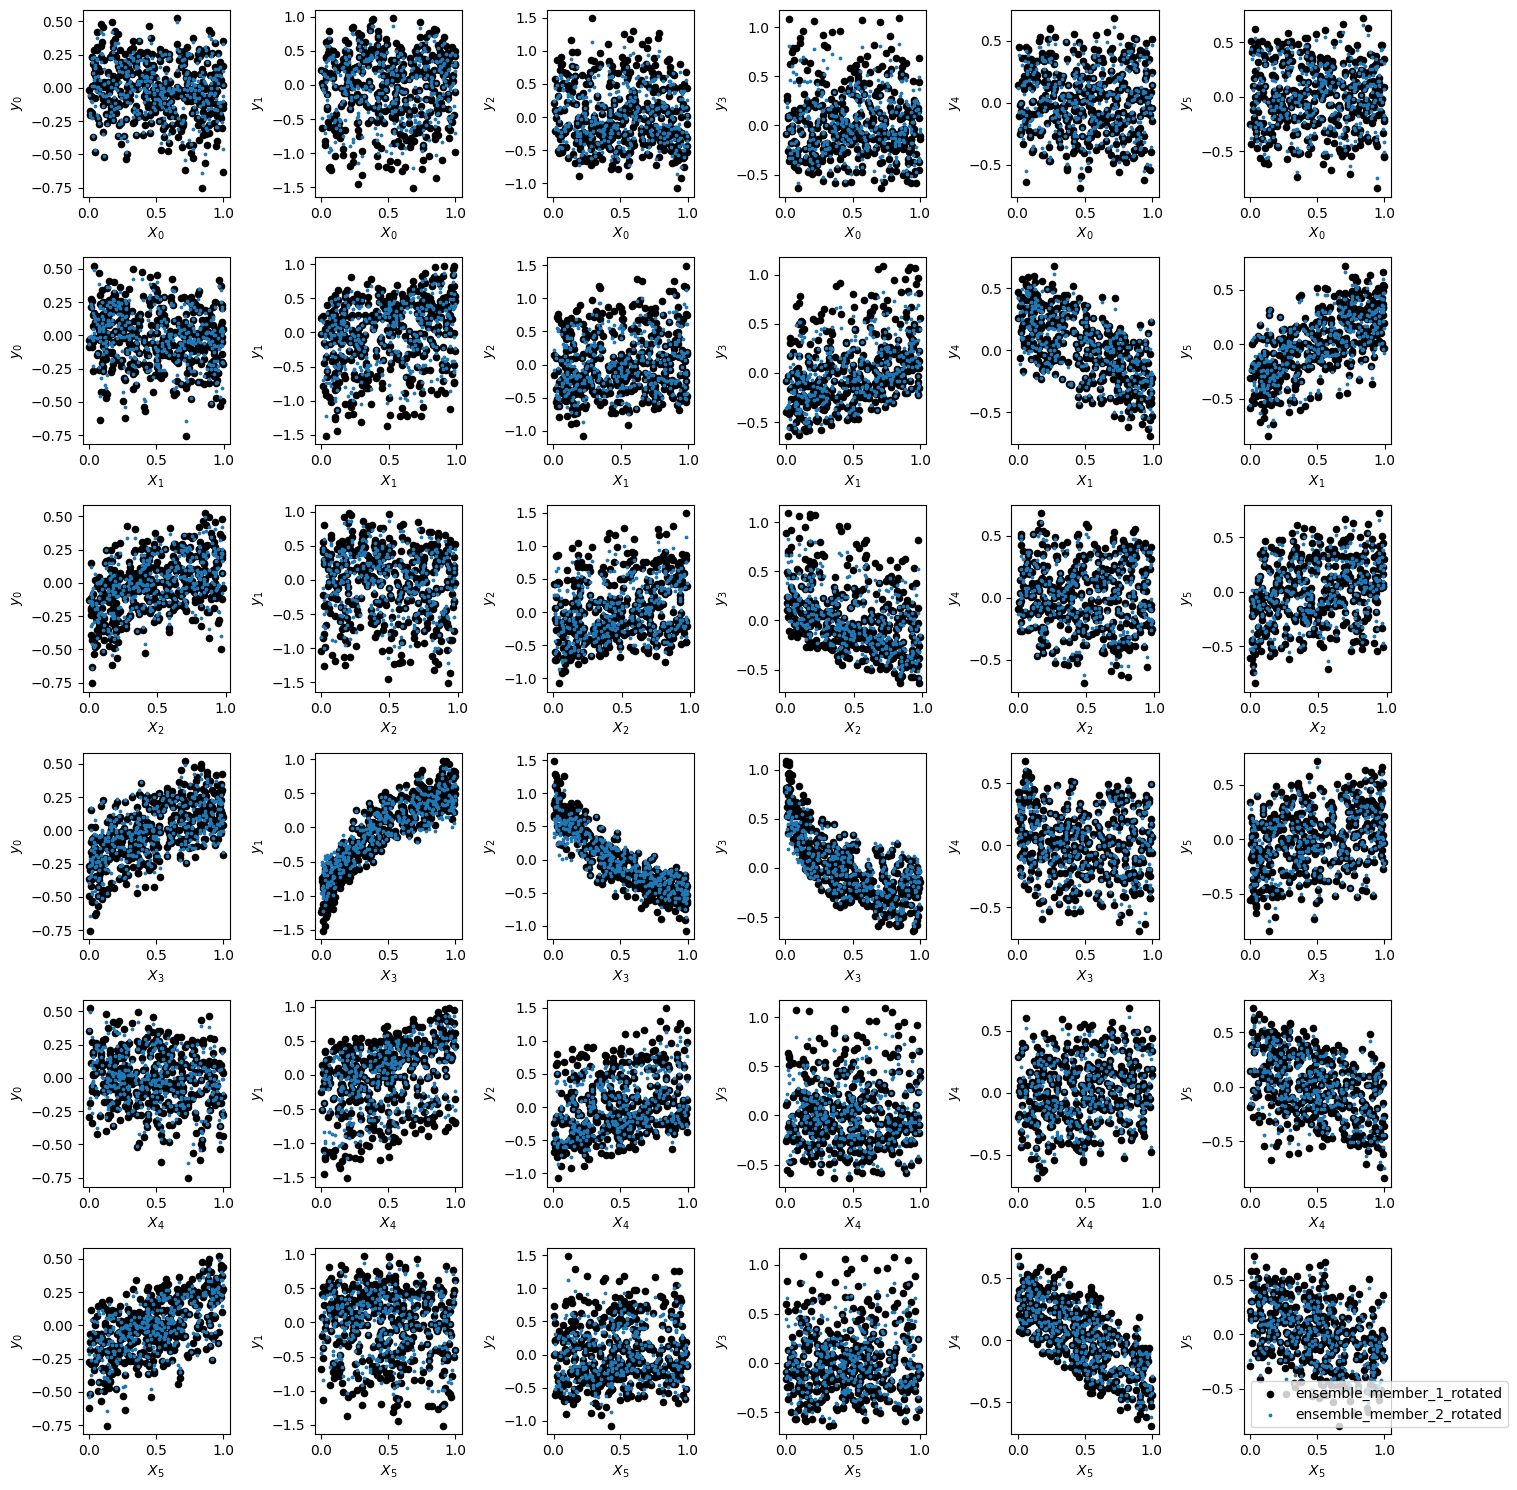

In [8]:
# repeat same test but for a different ensemble member (same perturbed orthogonal matrix)

ytest = data['eta_ensemble'][15]

ytest_rot, *_ = rotate_coords(ytest, X, Fs, data["dys"][0], y_reference= data['eta_ensemble'][2])

ytest_p = np.einsum("ij,bj->bi", R, ytest)

ytest_p = data['eta_ensemble'][0]

ytest_p_rot, *_ = rotate_coords(ytest_p, X, Fs, data["dys"][0],  y_reference= data['eta_ensemble'][2])



fig, axs = plt.subplots(6, 6, figsize=(15,15))

skip=10

for i in range(X.shape[-1]):
    for j in range(y.shape[-1]):
        
        # row, column
        # axs[i,j].scatter(X[::skip,i], ytest[::skip, j], label='ensemble_member_1', s=3)
        axs[i,j].scatter(X[::skip,i], ytest_rot[::skip, j], label='ensemble_member_1_rotated', s=20, c='k')
        # axs[i,j].scatter(X[::skip,i], ytest_p[::skip, j], label='ensemble_member_2', s=3)
        axs[i,j].scatter(X[::skip,i], ytest_p_rot[::skip, j], label='ensemble_member_2_rotated', s=3)


        axs[i,j].set_xlabel(r"$X_%d$"%(i))
        axs[i,j].set_ylabel(r"$y_%d$"%(j))

plt.legend()
plt.tight_layout()
plt.show()

thetastar [0.6315514  0.44120693 0.54719007 0.44854033 0.4729259  0.46151984]
rotmat [[ 0.9701772   0.03802625 -0.12702024 -0.04779655  0.1311115  -0.14731523]
 [-0.01773015  0.8905521  -0.01582268 -0.38940275 -0.02279719  0.2328054 ]
 [ 0.10388238  0.06709096  0.9833782   0.05218483  0.08681546 -0.08610851]
 [-0.12007271  0.34032816 -0.08639254  0.2772645  -0.17008886 -0.8697645 ]
 [-0.1616172   0.0688276  -0.08607374  0.03975111  0.9725329  -0.11972165]
 [ 0.08433953  0.28356558 -0.04136229  0.8745868   0.00155395  0.38191894]]
thetastar [0.6315514  0.44120693 0.54719007 0.44854033 0.4729259  0.46151984]
rotmat [[ 0.93149483  0.15523934 -0.22724831 -0.1277732  -0.16749512 -0.11043367]
 [-0.19088045  0.88218224 -0.02537316 -0.33515853 -0.11433318  0.24345744]
 [ 0.19773409  0.14899182  0.9436339   0.03556716  0.06640434 -0.2063552 ]
 [-0.2007416   0.24410978 -0.18169022  0.20440501 -0.21810482 -0.8819018 ]
 [ 0.09349686  0.21516924 -0.15441987  0.10106164  0.94409156 -0.13997123]
 [ 0

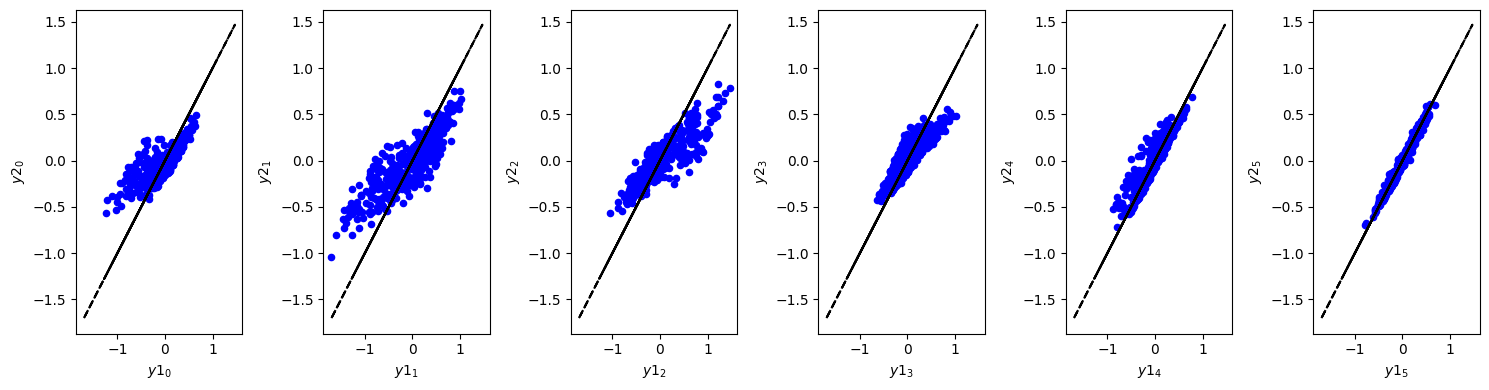

In [9]:
# repeat same test but for a different ensemble member (same perturbed orthogonal matrix)

ytest = data['eta_ensemble'][3]

ytest_rot, *_ = rotate_coords(ytest, X, Fs, data['dys'][0], y_reference= data['eta_ensemble'][0])

ytest_p = np.einsum("ij,bj->bi", R, ytest)

ytest_p = data['eta_ensemble'][6]

ytest_p_rot, *_ = rotate_coords(ytest_p, X, Fs, data['dys'][0],  y_reference= data['eta_ensemble'][0])

# ytest_p_rot = ytest_p

fig, axs = plt.subplots(1, 6, figsize=(15,4))

skip=10

for i in range(X.shape[-1]):

        
    # row, column
    # axs[i,j].scatter(X[::skip,i], ytest[::skip, j], label='ensemble_member_1', s=3)
    axs[i].scatter(ytest_rot[::skip,i], ytest_p_rot[::skip, i], label='ensemble_member_1_rotated', s=20, c='blue')
    axs[i].plot(ytest_rot, ytest_rot, c='k', ls='--')
    # axs[i,j].scatter(X[::skip,i], ytest_p[::skip, j], label='ensemble_member_2', s=3)
    # axs[i,j].scatter(X[::skip,i], ytest_p_rot[::skip, j], label='ensemble_member_2_rotated', s=3)


    axs[i].set_xlabel(r"$y1_%d$"%(i))
    axs[i].set_ylabel(r"$y2_%d$"%(i))

# plt.legend()
plt.tight_layout()
plt.show()

(array([432., 432., 371., 415., 429., 371., 429., 373., 394., 354.]),
 array([3.96490097e-04, 1.00311801e-01, 2.00227112e-01, 3.00142437e-01,
        4.00057733e-01, 4.99973059e-01, 5.99888384e-01, 6.99803710e-01,
        7.99718976e-01, 8.99634302e-01, 9.99549627e-01]),
 <BarContainer object of 10 artists>)

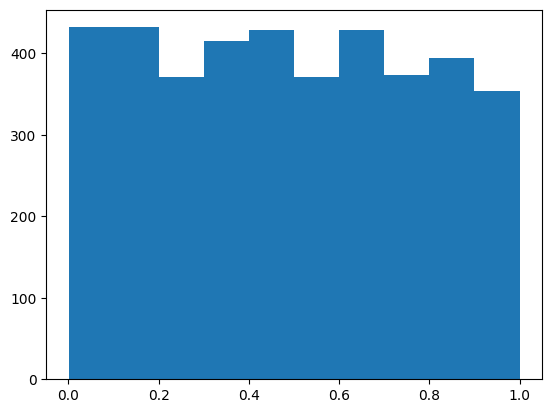

In [15]:
plt.hist(X[:, 2])

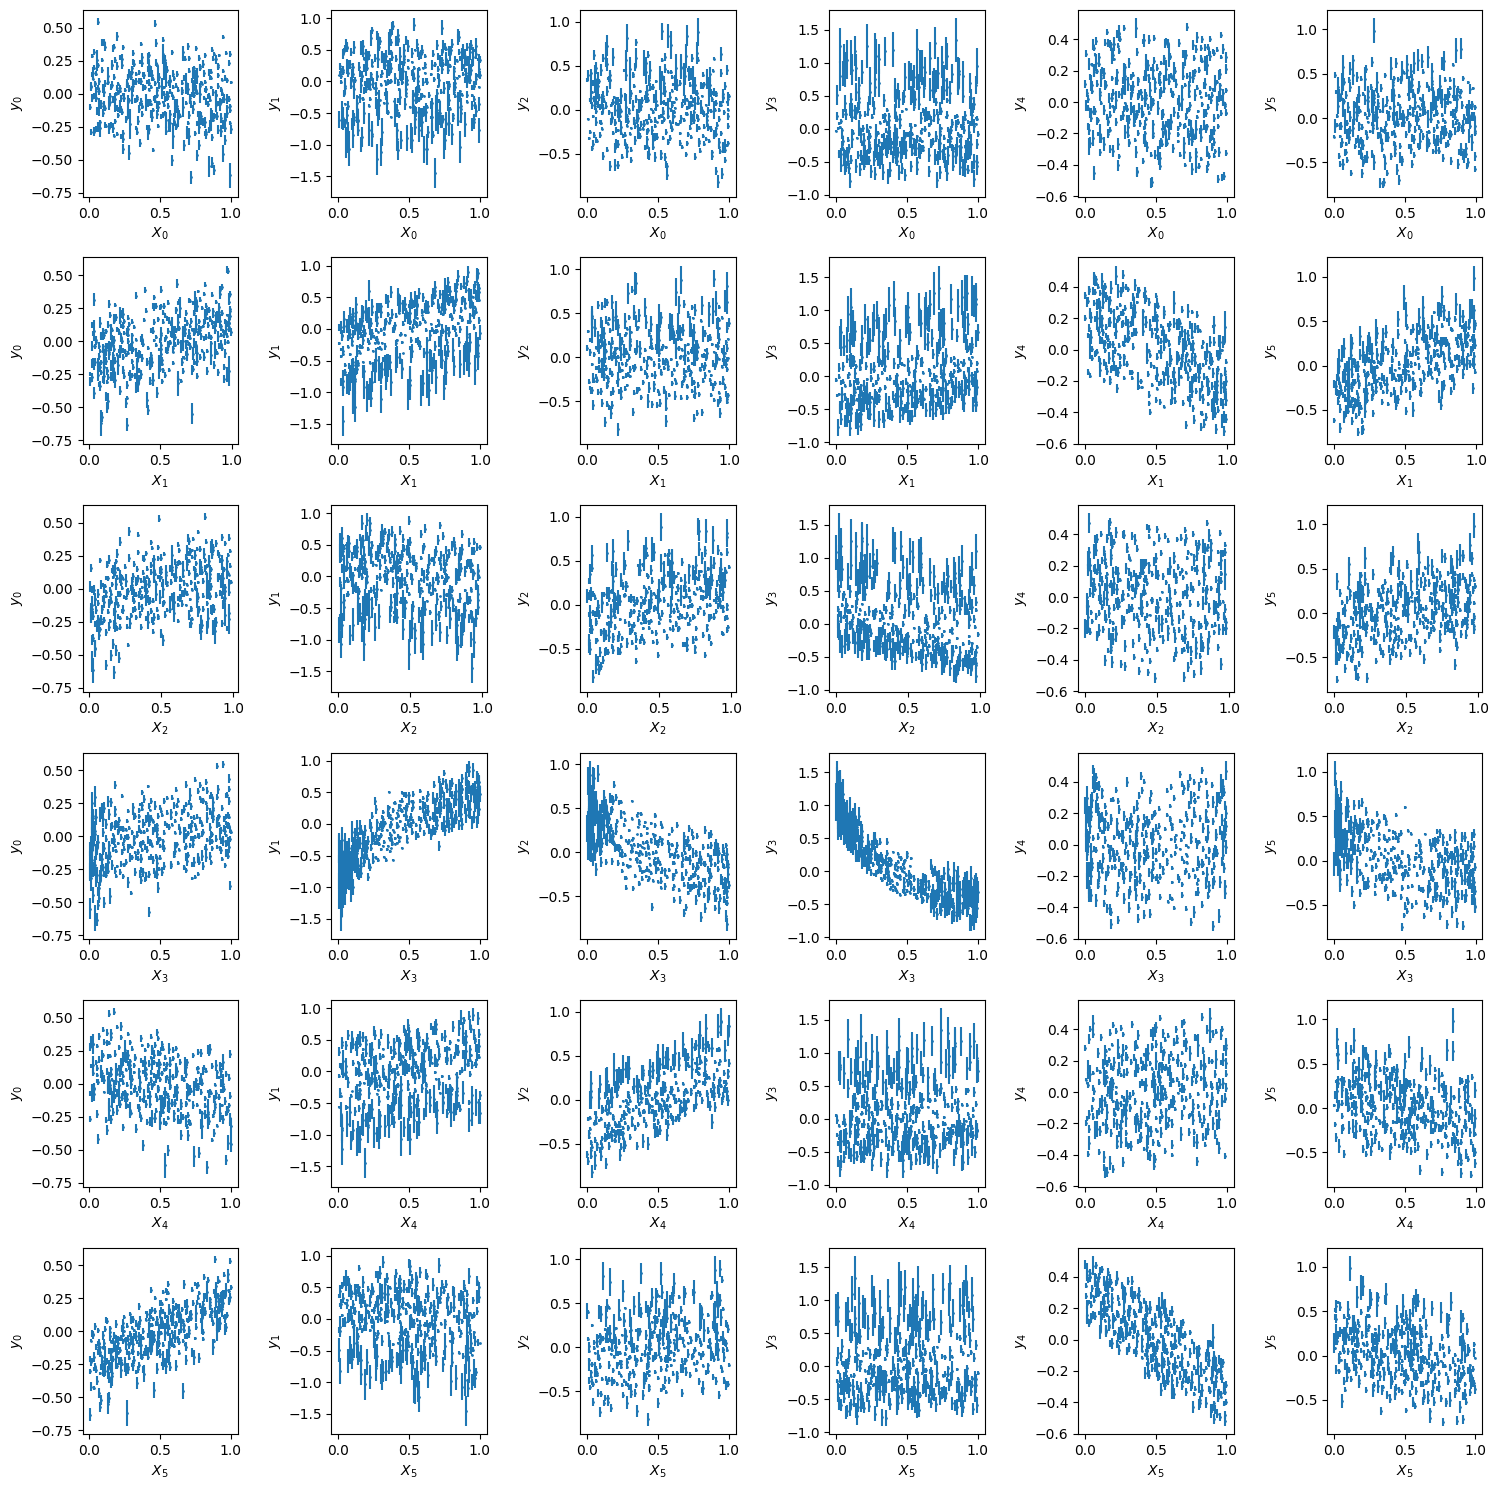

In [10]:
# create scatterplot to see how y responds to X

fig, axs = plt.subplots(6, 6, figsize=(15,15))

skip=10

for i in range(X.shape[-1]):
    for j in range(y.shape[-1]):
        
        # row, column
        axs[i,j].errorbar(X[::skip,i], y[::skip, j], yerr=y_std[::skip, j], label='', fmt='o', markersize=1)

        axs[i,j].set_xlabel(r"$X_%d$"%(i))
        axs[i,j].set_ylabel(r"$y_%d$"%(j))

plt.tight_layout()
plt.show()

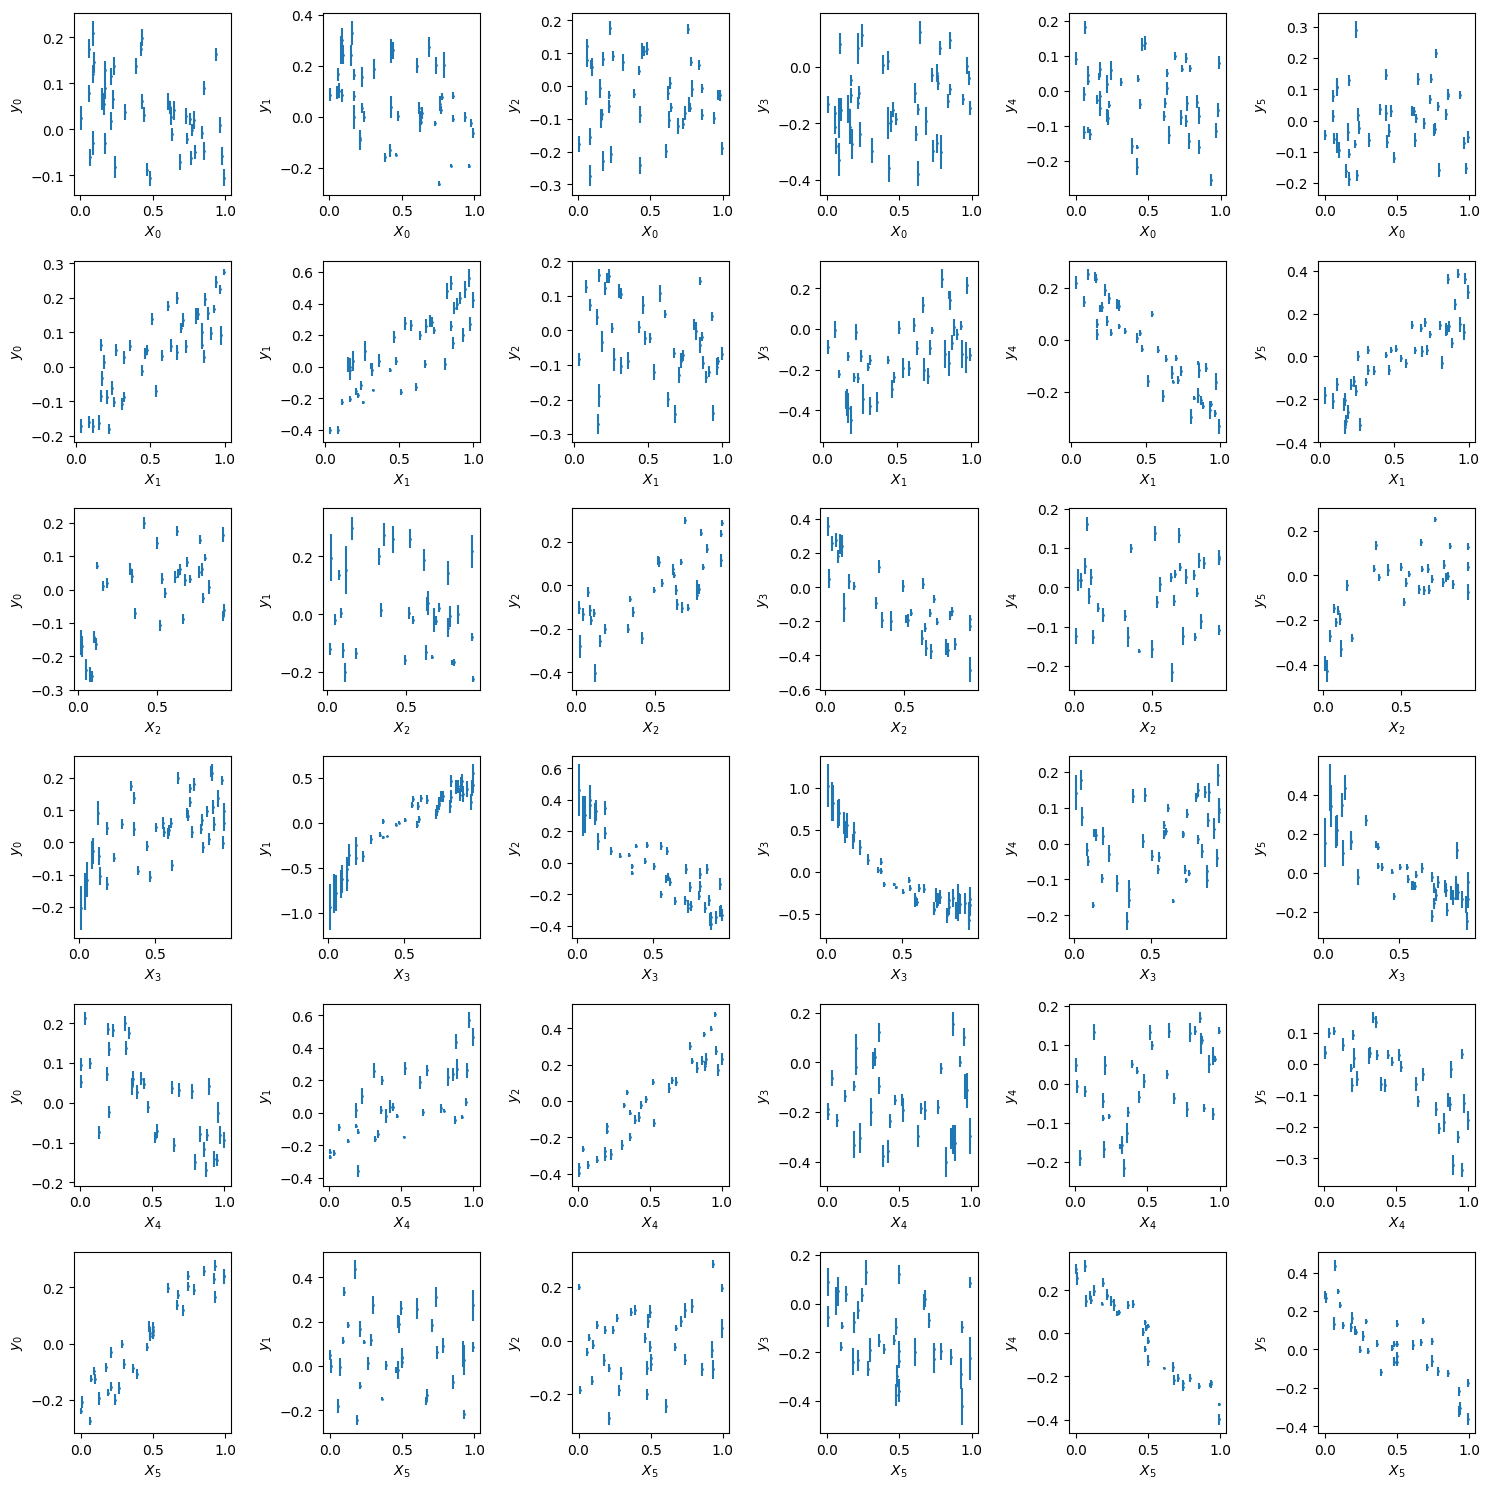

In [11]:
# plot within a small neighbourhood

fig, axs = plt.subplots(6, 6, figsize=(15,15))

skip=1

for i in range(X.shape[-1]):
    for j in range(y.shape[-1]):

        # mask close to the parameter value at hand
        eps = 0.2
        idxs = [l for l in np.arange(X.shape[-1]) if l != i ]

        msk = np.ones(X.shape[0]).astype(bool)

        fid = X.mean(0)
        fidmin = fid - eps
        fidmax = fid + eps

        for l in idxs:
            msk &= (X[:, l] > fidmin[l])
            msk &= (X[:, l] < fidmax[l])
        
        _x = X[msk]
        _y = y[msk]
        _yerr = y_std[msk]
        
        # row, column
        axs[i,j].errorbar(_x[::skip,i], _y[::skip, j], yerr=_yerr[::skip, j], label='', fmt='o', markersize=1)

        axs[i,j].set_xlabel(r"$X_%d$"%(i))
        axs[i,j].set_ylabel(r"$y_%d$"%(j))

plt.tight_layout()

In [19]:
y[0]

array([ 0.03596622,  0.5964111 , -0.42346328, -0.3249222 ,  0.22228497,
        0.26591116], dtype=float32)

In [20]:
np.cov(y, rowvar=False).shape

Text(0, 0.5, '$y$')

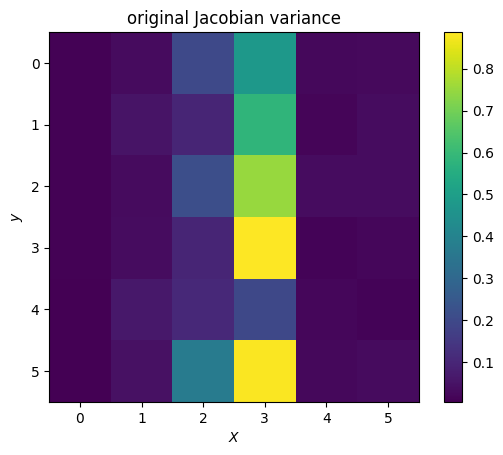

In [12]:
plt.imshow(dy.std(0))
plt.colorbar()
plt.title('original Jacobian variance')
plt.xlabel("$X$")
plt.ylabel("$y$")

Text(0, 0.5, '$y$')

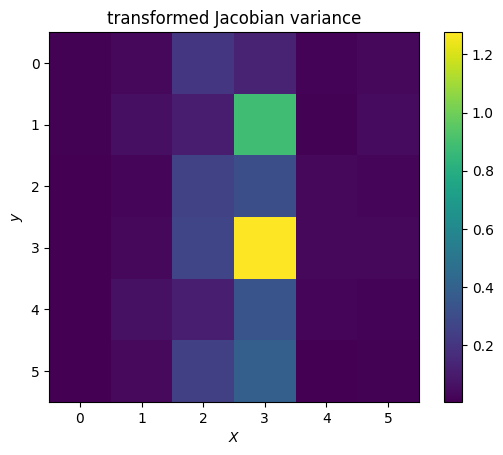

In [13]:
plt.imshow(dy_sr.std(0))
plt.colorbar()
plt.title('transformed Jacobian variance')
plt.xlabel("$X$")

plt.ylabel("$y$")

Text(0, 0.5, '$y$')

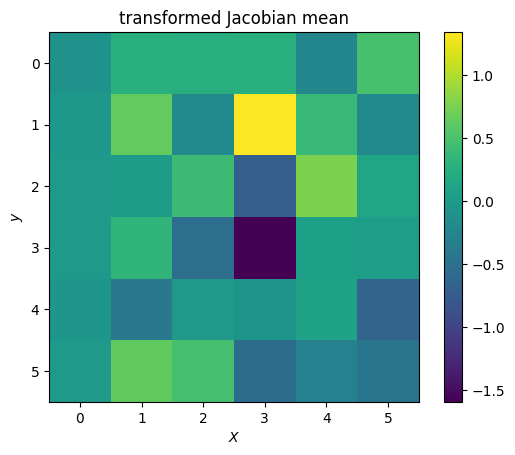

In [14]:
plt.imshow(dy_sr.mean(0))
plt.colorbar()
plt.title('transformed Jacobian mean')
plt.xlabel("$X$")
plt.ylabel("$y$")

In [15]:
np.dot(dy_sr[45, 0, :], dy_sr[45, 1, :])

0.015216632

Text(0, 0.5, '$y$')

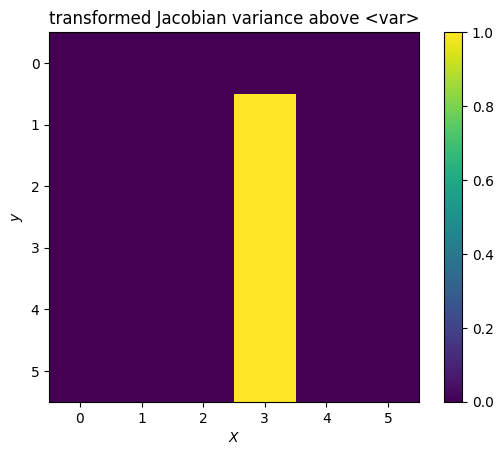

In [16]:
plt.imshow(dy_sr.var(0) > (dy_sr.var(0).mean()))
plt.colorbar()
plt.title('transformed Jacobian variance above <var>')
plt.xlabel("$X$")
plt.ylabel("$y$")

Text(0, 0.5, '$y$')

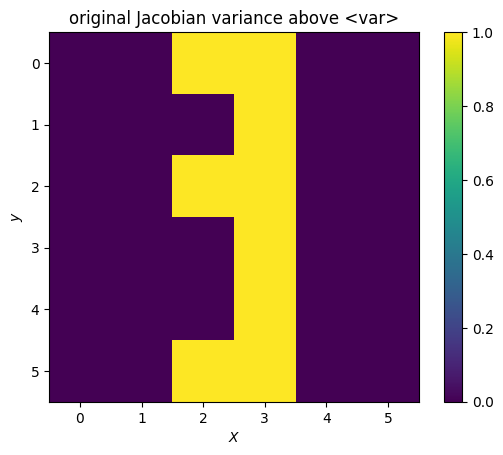

In [17]:
plt.imshow(dy.std(0) > (dy.std(0).mean()))
plt.colorbar()
plt.title('original Jacobian variance above <var>')
plt.xlabel("$X$")
plt.ylabel("$y$")

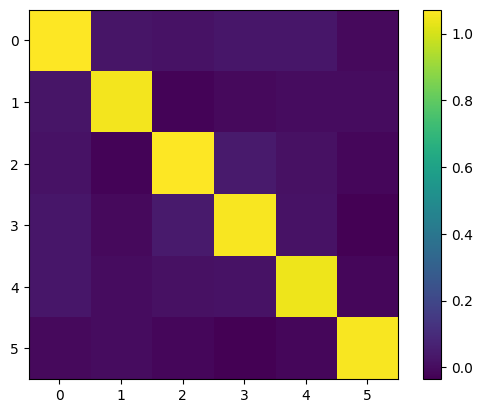

In [18]:
# foo = dy_sr / np.sqrt(0.5)
plt.imshow(jax.vmap(flatten_with_numerical_jacobian)(dy, Fs).mean(0))
plt.colorbar()

Text(0, 0.5, '$\\langle\\eta_{0,j}\\rangle$')

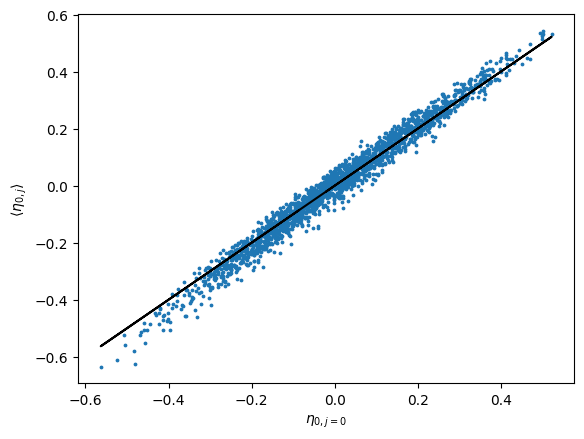

In [19]:
plt.scatter(data['ys'][0, ::2, 0], np.average(data['ys'][1:, ::2, 0], axis=0, \
                            weights=(data['ensemble_weights'][1:])), s=3) 

plt.plot(data['ys'][0, ::2, 0],data['ys'][0, ::2, 0], c='k')
plt.xlabel(r"$\eta_{0,j=0}$")
plt.ylabel(r"$\langle\eta_{0,j}\rangle$")

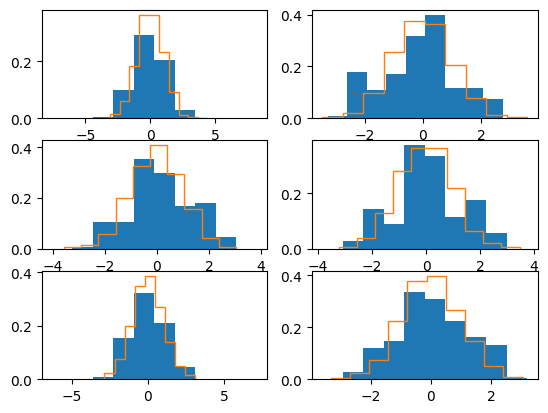

In [20]:
fig,axs = plt.subplots(3,2)
axs = axs.flatten()

for i,ax in enumerate(axs):
    ax.hist(((data['ys'] - y) / y_std)[:, :, i].flatten(), density=True)
    ax.hist(np.random.normal(size=(2000,)).flatten(), histtype='step', density=True)

In [30]:
(np.sqrt(np.linalg.det(Fs).mean()))

0.3984412

In [21]:
# Some parameters for operon
parent_dir = './fake_cmb_21_01/'


allowed_symbols = 'add,mul,pow,constant,variable,logabs,exp,sqrt,square' # logabs exp sqrt square
epsilon = 1e-5 # 1e-5
max_length = 25 # 25
max_depth = 10 #20 #10 # 8
time_limit = 60 * 2 # s
objectives=['r2', 'length'] #['rmse', 'length']#['rmse', 'length']
max_evaluations=1e8
generations=1e8



In [ ]:
# X -= X.mean(0) # try zero-centering


components_to_fit = [0, 1, 2, 3, 4, 5]


if not os.path.isdir(parent_dir):
    os.mkdir(parent_dir)

n_components = len(components_to_fit)

halfx = X.shape[0] // 2


for i in range(n_components):

    out_dir = parent_dir + "component_%d"%(i+1)
    
    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)


    Xfit = X[:halfx]
    yfit = y[:halfx, i]
    y_std_fit = y_std[:halfx]
        
    reg = SymbolicRegressor(
                allowed_symbols=allowed_symbols,
                offspring_generator='basic',
                optimizer_iterations=10, # 1000
                max_length=max_length,
                max_depth=max_depth,
                initialization_method='btc',
                n_threads=multiprocessing.cpu_count(),
                objectives = objectives,
                epsilon = epsilon,
                random_state=2345,
                reinserter='keep-best',
                max_evaluations=int(max_evaluations),
                symbolic_mode=False,
                #max_time=int(time_limit),
                time_limit=int(time_limit),
                generations=int(generations),
                add_model_scale_term           = True,
                add_model_intercept_term       = True,
               #uncertainty=y_std_fit[:, i],
    )

    print("X train shape", Xfit.shape, "y train shape", yfit.shape)

    print('Fitting')
    reg.fit(Xfit, yfit) #, sample_weight = 1. / y_std_fit[:, i]**2.)
    print('Done')
    print(reg.get_model_string(reg.model_, 2))
    print(reg.stats_)


    # Save Pareto front
    with open(f'{out_dir}/pareto.csv', 'w') as f:
        
        writer = csv.writer(f, delimiter=';')
        writer.writerow(['length',
                        'mse',
                        'model',
        ])
        
        print(f'Outputting {len(reg.pareto_front_)} individuals on Pareto front')
        
        for i in range(len(reg.pareto_front_)):
            writer.writerow([reg.pareto_front_[i]['tree'].Length,
                            reg.pareto_front_[i]['mean_squared_error'],
                            reg.pareto_front_[i]['model'],
                            ])
            
    # Save population
    print(f'Outputting {len(reg.individuals_)} individuals in population')
    with open(f'{out_dir}/final_population.csv', 'w') as f:
        
        writer = csv.writer(f, delimiter=';')
        writer.writerow(['length',
                        'mse',
                        'model',
        ])
        for ind in reg.individuals_[:reg.population_size]:
            tree = ind.Genotype
            
            # Get name but block printing to sys.stderr
            sys.stderr = open(os.devnull, 'w')
            s = reg.get_model_string(ind.Genotype, 10)
            sys.stderr = sys.__stderr__
            
            y_pred = reg.evaluate_model(tree, Xfit)
            mse = np.mean((yfit - y_pred)**2)
            
            writer.writerow([tree.Length,
                            mse,
                            s
                            ])

X train shape (2000, 6) y train shape (2000,)
Fitting
Done
((-0.23) + (3.95 * (0.12 * X6)))
{'model_length': 1, 'model_complexity': 3, 'generations': 1514, 'evaluation_count': 0, 'residual_evaluations': 10157759, 'jacobian_evaluations': 5965189, 'random_state': 2345}
Outputting 22 individuals on Pareto front
Outputting 2000 individuals in population
X train shape (2000, 6) y train shape (2000,)
Fitting
Done
(0.13 + ((-1.46) * (((-0.28) * X5) + (((-0.44) * X2) + exp(((-1.92) * X4))))))
{'model_length': 6, 'model_complexity': 12, 'generations': 978, 'evaluation_count': 0, 'residual_evaluations': 6969363, 'jacobian_evaluations': 4877708, 'random_state': 2345}
Outputting 23 individuals on Pareto front
Outputting 2000 individuals in population
X train shape (2000, 6) y train shape (2000,)
Fitting
Done
((-0.04) + (1.00 * (((-0.67) * X4) + (0.76 * X5))))
{'model_length': 3, 'model_complexity': 7, 'generations': 815, 'evaluation_count': 0, 'residual_evaluations': 6604985, 'jacobian_evaluations

8it [00:12,  1.55s/it]
9it [00:02,  3.20it/s]
8it [00:01,  4.73it/s]
9it [00:02,  4.26it/s]
8it [00:02,  3.80it/s]
6it [00:01,  5.45it/s]
/var/folders/pg/xm7nmkzn0tq26tlbl6skh5080000gp/T/ipykernel_5682/4231390616.py:23: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  res = minimize(_lossfn, x0=Ainit.flatten(),
/usr/local/Caskroom/miniconda/base/envs/pyoperon/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:6633: UserWarning: Explicitly requested dtype float64 requested in eye is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  output = _eye(N, M=M, k=k, dtype=dtype)
/usr/local/Caskroom/miniconda/base/envs/pyoperon/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitl

In [22]:
halfx = X.shape[0] // 2
print(halfx)
# switch to validation set
X = X[halfx:]
y = y[halfx:]
y_std = y_std[halfx:]
dy = dy[halfx:]
dy_sr = dy_sr[halfx:]

Fs = Fs[halfx:]


2000


In [23]:
Fs.shape, X.shape, y.shape, y_std.shape, dy_sr.shape

In [24]:
import jax
jax.config.update("jax_debug_nans", False)

In [25]:
import sympy

n_params = 6

@jax.jit
def norm(A):
    return jnp.sqrt(jnp.einsum('ij,ij->', A, A))


def split_by_punctuation(s):
    """
    Convert a string into a list, where the string is split by punctuation,
    excluding underscores or full stops.
    
    For example, the string 'he_ll*o.w0%rl^d' becomes
    ['he_ll', '*', 'o.w0', '%', 'rl', '^', 'd']
    
    Args:
        :s (str): The string to split up
        
    Returns
        :split_str (list[str]): The string split by punctuation
    
    """
    pun = string.punctuation.replace('_', '') # allow underscores in variable names
    pun = string.punctuation.replace('.', '') # allow full stops
    pun = pun + ' '
    where_pun = [i for i in range(len(s)) if s[i] in pun]
    if len(where_pun) > 0:
        split_str = [s[:where_pun[0]]]
        for i in range(len(where_pun)-1):
            split_str += [s[where_pun[i]]]
            split_str += [s[where_pun[i]+1:where_pun[i+1]]]
        split_str += [s[where_pun[-1]]]
        if where_pun[-1] != len(s) - 1:
            split_str += [s[where_pun[-1]+1:]]
    else:
        split_str = [s]
        
    # Remove spaces
    split_str = [s.strip() for s in split_str if len(s) > 0 and (not s.isspace())]
    
    return split_str

def is_float(s):
    """
    Function to determine whether a string has a numeric value
    
    Args:
        :s (str): The string of interest
        
    Returns:
        :bool: True if s has a numeric value, False otherwise
        
    """
    try:
        float(eval(s))
        return True
    except:
        return False

def replace_floats(s):
    """
    Replace the floats in a string by parameters named b0, b1, ...
    where each float (even if they have the same value) is assigned a
    different b.
    
    Args:
        :s (str): The string to consider
        
    Returns:
        :replaced (str): The same string, but with floats replaced by parameter names
        :values (list[float]): The values of the parameters in order [b0, b1, ...]
        
    """
    split_str = split_by_punctuation(s)
    values = []
    
    # Initial pass at replacing floats
    for i in range(len(split_str)):
        if is_float(split_str[i]) and "." in split_str[i]:
            values.append(float(split_str[i]))
            split_str[i] = f'b{len(values)-1}'
        elif len(split_str[i]) > 1 and split_str[i][-1] == 'e' and is_float(split_str[i][:-1]):
            if split_str[i+1] in ['+', '-']:
                values.append(float(''.join(split_str[i:i+3])))
                split_str[i] = f'b{len(values)-1}'
                split_str[i+1] = ''
                split_str[i+2] = ''
            else:
                assert split_str[i+1].is_digit()
                values.append(float(''.join(split_str[i:i+2])))
                split_str[i] = f'b{len(values)-1}'
                split_str[i+1] = ''
    
    # Now check for negative parameters
    for i in range(len(values)):
        idx = split_str.index(f'b{i}')
        if (idx == 1) and (split_str[0] == '-'):
            split_str[0] = ''
            values[i] *= -1
        elif (split_str[idx-1] == '-') and (split_str[idx-2] in ['+','-','*','/','(','^']):
            values[i] *= -1
            split_str[idx-1] = ''

    # Rejoin string
    replaced = ''.join(split_str)

    return replaced, values


def compute_DL(eq, idx):

    component_idx = idx #components_to_fit[idx] # slot in the component that we're fitting in terms of where it falls in y vector

    basis_functions = [["X", "b"],  # type0
            ["square", "exp", "inv", "sqrt", "log", "cos", "logAbs"],  # type1
            ["+", "*", "-", "/", "^"]]  # type2

    a, b = sympy.symbols('a b', real=True)
    sympy.init_printing(use_unicode=True)
    inv = sympy.Lambda(a, 1/a)
    square = sympy.Lambda(a, a*a)
    cube = sympy.Lambda(a, a*a*a)
    sqrt = sympy.Lambda(a, sympy.sqrt(a))
    log = sympy.Lambda(a, sympy.log(a))
    logAbs = sympy.Lambda(a, sympy.log(sympy.Abs(a)))
    power = sympy.Lambda((a,b), sympy.Pow(a, b))

    sympy_locs = {"inv": inv,
                "square": square,
                "cube": cube,
                "cos": sympy.cos,
                "^": power,
                "Abs": sympy.Abs,
                "sqrt":sqrt,
                "log":log,
                "logAbs":logAbs
                }
    
    expr, pars = replace_floats(eq)
    expr, nodes, c = esr.generation.generator.string_to_node(
        expr, 
        basis_functions, 
        evalf=True, 
        allow_eval=True, 
        check_ops=True, 
        locs=sympy_locs
    )
    param_list = [f"b{i}" for i in range(len(pars))]
    labels = nodes.to_list(basis_functions)
    latex_expr = sympy.latex(expr)
    
    # klog(n) + \sum_i log |c_i|
    aifeyn = esr.generation.generator.aifeyn_complexity(labels, param_list)
    
    # Turn function into callable object
    all_x = ' '.join([f'X{i}' for i in range(1, X.shape[1] + 1)])
    all_x = list(sympy.symbols(all_x, real=True))
    all_b = list(sympy.symbols(param_list, real=True))
    eq_jax = sympy.lambdify(all_b + all_x, expr, modules=["jax"])


    def myloss(p):
        ypred = eq_jax(*p, *X.T)
        result = jnp.sum((y[:, component_idx] - ypred)**2 / 2 / y_std[:, component_idx]**2)
        return result
    


    
    # GET ROWS OF JACOBIAN AND CHECK FLATTENING per component
    def frob_loss(p):

        def get_jac_row(p):
            myeq = lambda *args: eq_jax(*p, *args)

            # THIS IS FOR A SINGLE COMPONENT
            yjac = jax.jacrev(myeq, argnums=list(range(0, X.shape[1])))
            Jpred = jnp.array(jax.vmap(yjac)(*X.T)).T

            return Jpred

        jac_row = get_jac_row(pars)
        # assign the SR expression's jacobian row to a copy of the network Jac
        jacobian = dy_sr.copy()
        jacobian[:, component_idx, :] = np.array(jac_row)

        def flatten_fisher(J, F):
            invJ = jnp.linalg.pinv(J)
            return invJ.T @ F @ invJ

        flats = jax.vmap(flatten_fisher)(jacobian, Fs)
        nn_flats = jax.vmap(flatten_fisher)(dy_sr, Fs)
        fn = lambda q: norm((q - jnp.eye(n_params))) + norm((jnp.linalg.pinv(q) - jnp.eye(n_params)))

        return np.mean(jax.vmap(fn)(flats) - jax.vmap(fn)(nn_flats))
    


    neglogL = myloss(pars)
    frobloss = frob_loss(pars) # frob_loss_batched(pars) #  
    #all_logL[i] = neglogL
    
    if len(pars) == 0:
        param_codelen = 0
    else:
        theta_ML = np.array(pars)

        # Compute loss and Hessian
        hessian_myloss = jax.hessian(myloss)
        I_ii = np.diag(np.array(hessian_myloss(pars)))

        # Check the Hessian is valid
        #if np.any(I_ii < 0):
        #   return c, latex_expr, neglogL, np.nan
            
        # Remove parameters which do not affect the likelihood or zero parameters
        kept_mask = (I_ii > 0) & (theta_ML != 0)
        theta_ML = theta_ML[kept_mask]
        I_ii = I_ii[kept_mask]
        
        # If the error is bigger than the parameter value, we can just set the
        # precision to the parameter value
        Delta = np.sqrt(12./I_ii)
        nsteps = np.abs(np.array(theta_ML))/Delta
        m = nsteps < 1
        I_ii[m] = 12 / theta_ML[m] ** 2
        
        # Compute parameter part of codelength
        p = len(theta_ML) - np.sum(m) # subtract out sum of mask => params == 0
        param_codelen = -p/2.*np.log(3.) + np.sum( 0.5*np.log(I_ii) + np.log(abs(np.array(theta_ML))) )
    
    # Combine the terms
    DL = neglogL + aifeyn + param_codelen
    
    return c, latex_expr, neglogL, DL, frobloss

In [26]:
parent_dir

'./fake_cmb_21_01/'

analysing 1 of 6 nonlinear components
fitting y component 0
8 equations below complexity threshold


0it [00:00, ?it/s]

8it [00:02,  3.91it/s]


Best equation: ((-0.413300) + (1.044893 * (((-0.230839) * X5) + ((((0.245566 * X4) + (0.459738 * X6)) + (0.264418 * X2)) + sqrt((0.001539 * X3))))))
Best frob loss equation: ((-0.413300) + (1.044893 * (((-0.230839) * X5) + ((((0.245566 * X4) + (0.459738 * X6)) + (0.264418 * X2)) + sqrt((0.001539 * X3))))))


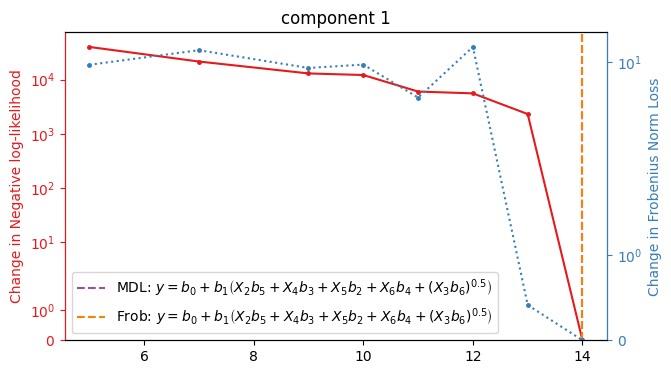

analysing 2 of 6 nonlinear components
fitting y component 1
9 equations below complexity threshold


9it [00:02,  4.49it/s]


Best equation: (0.024954 + ((-1.408808) * (((-0.281556) * X5) + (((-0.454741) * X2) + ((((-0.036536) * X3) * ((-0.096053) * X6)) ^ (0.314051 * X4))))))
Best frob loss equation: (0.147687 + ((-1.417460) * (((-0.281556) * X5) + (((-0.449306) * X2) + ((0.136777 * X6) + exp(((-2.245954) * X4)))))))


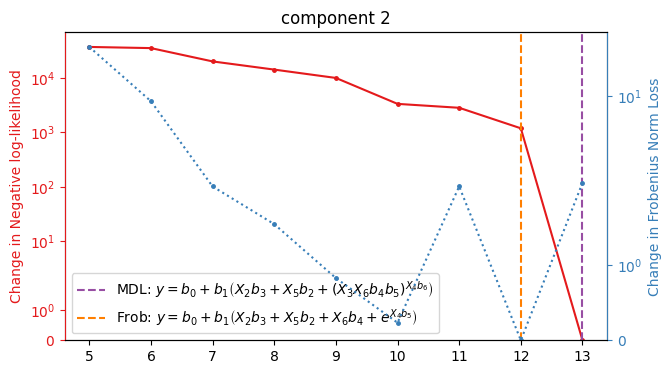

analysing 3 of 6 nonlinear components
fitting y component 2
8 equations below complexity threshold


8it [00:01,  4.50it/s]


Best equation: ((-1.284770) + (0.998743 * (sqrt((0.200012 * X3)) + (((0.758954 * X5) + (0.133009 * X6)) + ((0.000006 * X4) ^ (0.105453 * X4))))))
Best frob loss equation: ((-1.284770) + (0.998743 * (sqrt((0.200012 * X3)) + (((0.758954 * X5) + (0.133009 * X6)) + ((0.000006 * X4) ^ (0.105453 * X4))))))


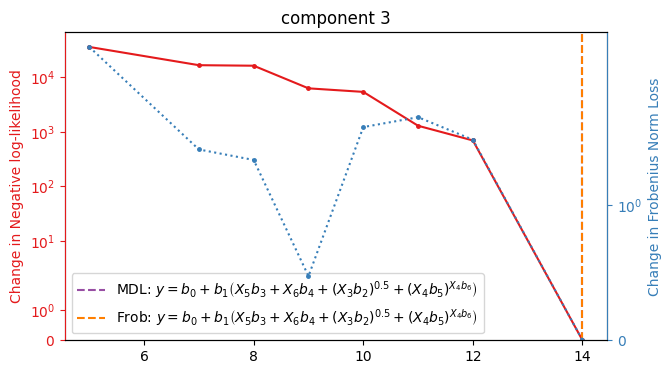

analysing 4 of 6 nonlinear components
fitting y component 3
9 equations below complexity threshold


9it [00:01,  4.50it/s]


Best equation: ((-2.490759) + (0.985557 * (exp((0.009820 ^ (0.398186 * X4))) + (exp(((-0.672641) * X3)) + (0.328088 * X2)))))
Best frob loss equation: ((-2.490759) + (0.985557 * (exp((0.009820 ^ (0.398186 * X4))) + (exp(((-0.672641) * X3)) + (0.328088 * X2)))))


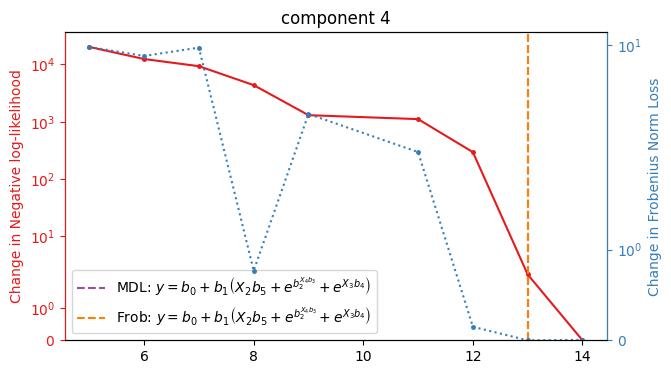

analysing 5 of 6 nonlinear components
fitting y component 4
8 equations below complexity threshold


8it [00:01,  4.19it/s]


Best equation: (0.000000 + (1.000000 * ((((((-0.057059) * X1) + ((-0.635158) * X6)) + (0.099190 * X5)) + 0.503686) + ((-0.420080) * X2))))
Best frob loss equation: (0.000000 + (1.000000 * ((((((-0.057059) * X1) + ((-0.635158) * X6)) + (0.099190 * X5)) + 0.503686) + ((-0.420080) * X2))))


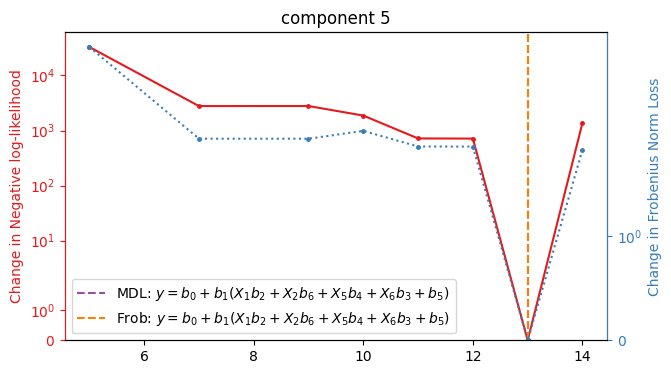

analysing 6 of 6 nonlinear components
fitting y component 5
6 equations below complexity threshold


6it [00:01,  4.24it/s]


Best equation: ((-0.034738) + (1.000000 * (((((-0.307070) * X5) + (0.625043 * X2)) + ((-0.449616) * X6)) + (((-0.487631) * X4) + sqrt((0.266289 * X3))))))
Best frob loss equation: ((-0.034738) + (1.000000 * (((((-0.307070) * X5) + (0.625043 * X2)) + ((-0.449616) * X6)) + (((-0.487631) * X4) + sqrt((0.266289 * X3))))))


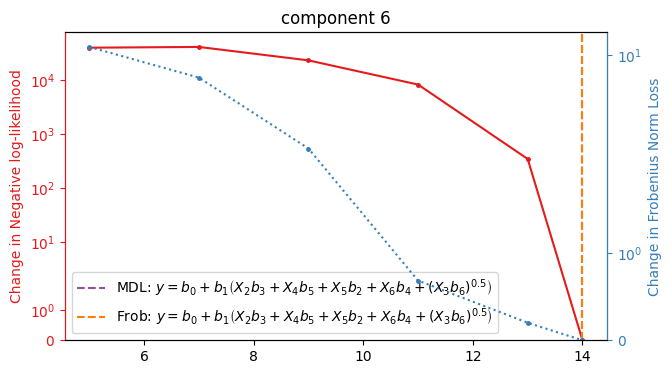

In [151]:
components_to_fit = [0,1,2,3,4,5]

mdl_coordinates = []
frob_coordinates = []
mse_threshold = 20 # 10
n_components = len(components_to_fit)

both_comp_latex = []
both_comp_eqs = []
both_comp_frobloss = []
both_comp_logL = []
both_comp_DL = []


max_complexity_thresh = 15

for i in range(n_components):

    idx = components_to_fit[i]
    
    print("analysing %d of %d nonlinear components"%(i+1, n_components))
    print("fitting y component %d"%(idx))

    outdir = parent_dir + "component_%d/"%(i + 1)
    # Find what description length (arXiv:2211.11461, Eq. 6) gives
    #data = pd.read_csv(outdir + 'final_population.csv', delimiter=";")

    data = pd.read_csv(outdir + 'pareto.csv', delimiter=";")[:]
 
    #mse_threshold = mse_thresholds[idx]
    loss = np.array(data["mse"])
    #mse_threshold = np.inf

    # mse_mask = (loss < mse_threshold)
    complexity = np.array(data["length"])
    mse_mask = (complexity < max_complexity_thresh)
    print("%d equations below complexity threshold"%(mse_mask.sum()))

    complexity = np.array(data["length"])[mse_mask]

    max_complexity = complexity.max()

    eqs = list(np.array(data['model'])[mse_mask])

    # chop some out to speed up code
    #eqs = eqs

    all_DL = np.ones(len(eqs)) * np.inf
    all_logL = np.ones(len(eqs)) * np.inf
    all_frobloss = np.ones(len(eqs)) * np.inf
    all_latex = [None] * len(eqs)

    for i, eq in tq(enumerate(eqs)):
        c, all_latex[i], all_logL[i], all_DL[i], all_frobloss[i] = compute_DL(eq, idx)

    # set nans to infs
    all_DL[np.isnan(all_DL)] = np.inf
    all_logL[np.isnan(all_logL)] = np.inf
    all_frobloss[np.isnan(all_frobloss)] = np.inf



    # Only changes in DL and logL matter
    #all_DL -= np.amin(all_DL)
    #all_logL -= np.amin(all_logL)

    # unique complexities
    # complexity = np.sort(np.unique(complexity))[1:] # remove comp=1 e.g. constants


    # get best DL model at given complexity
    pareto_DL = []
    pareto_logL = [] 
    pareto_latex = []
    pareto_eqs = []
    pareto_frobloss = []
    comps = []
    for comp in np.unique(complexity):
        if comp > 1:
            mask = (complexity == comp)
            ibest_model_at_complexity = np.argmin(all_DL[mask])
            pareto_DL.append(all_DL[mask][ibest_model_at_complexity])
            pareto_logL.append(all_logL[mask][ibest_model_at_complexity])
            pareto_frobloss.append(all_frobloss[mask][ibest_model_at_complexity])
            pareto_latex.append(np.array(all_latex)[mask][ibest_model_at_complexity])
            pareto_eqs.append(np.array(eqs)[mask][ibest_model_at_complexity])
            comps.append(comp)

    # redfine kept complexities
    complexity = np.array(comps)

    pareto_DL = np.array(pareto_DL)
    pareto_DL -= np.amin(pareto_DL)

    pareto_logL = np.array(pareto_logL)
    pareto_logL -= np.amin(pareto_logL)

    pareto_frobloss = np.array(pareto_frobloss)
    pareto_frobloss -= np.amin(pareto_frobloss)

    # store the latex and eq
    both_comp_latex.append(pareto_latex)
    both_comp_eqs.append(pareto_eqs)
    both_comp_frobloss.append(pareto_frobloss)
    both_comp_DL.append(pareto_DL)
    both_comp_logL.append(pareto_logL)

    # Print the best found equation
    ibest = np.argmin(pareto_DL)
    print('Best equation:', pareto_eqs[ibest])
    mdl_coordinates.append(pareto_eqs[ibest])

    # Print the best frob loss equation
    ibest_frob = np.argmin(pareto_frobloss)
    print('Best frob loss equation:', pareto_eqs[ibest_frob])
    frob_coordinates.append(pareto_eqs[ibest_frob])


    fig, ax1 = plt.subplots(1, 1, figsize=(7,4), sharex=True)
    cm = plt.get_cmap('Set1')
    ax2 = ax1.twinx()
    
    #ax1.plot(complexity, pareto_DL, marker='.', color=cm(0), markersize=5, )
    # ax2.plot(complexity, pareto_logL, marker='.', color=cm(1), markersize=5, ls=':')
    ax1.plot(complexity, pareto_logL, marker='.', color=cm(0), markersize=5, )
    ax2.plot(complexity, pareto_frobloss, marker='.', color=cm(1), markersize=5, ls=':')


    #ax1.set_ylabel('Change in Description Length')
    # ax2.set_ylabel('Change in Negative log-likelihood')
    ax1.set_ylabel('Change in Negative log-likelihood')
    ax2.set_ylabel('Change in Frobenius Norm Loss')
    ax1.yaxis.label.set_color(cm(0))
    ax1.tick_params(axis='y', colors=cm(0))
    ax2.spines['left'].set_color(cm(0))

    ax2.yaxis.label.set_color(cm(1))
    ax2.tick_params(axis='y', colors=cm(1))
    ax2.spines['right'].set_color(cm(1))

    ax1.set_yscale('symlog')
    ax2.set_yscale('symlog')
    ax1.set_ylim(0, None)
    ax2.set_ylim(0, None)

    #ax1.axvline(complexity[pysr_ibest], color=cm(2), ls=':', label=r'Score: $y = %s$'%all_latex[pysr_ibest])
    ax1.axvline(complexity[ibest], color=cm(3), ls='--', label=r'MDL: $y = %s$'%pareto_latex[ibest])
    ax1.axvline(complexity[ibest_frob], color=cm(4), ls='--', label=r'Frob: $y = %s$'%pareto_latex[ibest_frob])

    ax1.legend()
    plt.title("component %d"%(idx + 1))
    plt.show()
    #fig.savefig('function_ranking.png', bbox_inches='tight', facecolor='white')


In [72]:
mdl_coordinates

['((-0.607440) + (0.998977 * (((((-0.232967) * X5) + (((0.434294 * X6) + sqrt(((0.122733 * X4) + (0.020625 * X6)))) + ((-0.100918) * X1))) + (0.265574 * X2)) + sqrt((0.066680 * X3)))))',
 '(0.000001 + (1.000001 * (((0.383659 * X5) + ((((-0.757220) * X2) + exp(((0.122923 * X6) + exp(((-1.414600) * X4))))) * ((-0.786614) + ((-0.116372) * X3)))) + 1.061594)))',
 '((-1.313875) + (1.003488 * ((sqrt((0.198412 * X3)) + ((((((-0.012877) * X1) + (0.022446 * X2)) + (0.083912 * X6)) + ((0.000745 * X4) ^ (0.079527 * X4))) ^ 2)) + (0.755763 * X5))))',
 '((-0.000000) + (0.999961 * (((exp(((-1.044053) * X3)) + (-2.478776)) + (0.329284 * X2)) + (2.575984 ^ ((0.041537 * X5) + ((0.109732 * X3) + exp(((-1.901516) * X4))))))))',
 '(0.000000 + (1.000000 * (((-0.052825) * X1) + (((-0.417024) * X2) + ((((-0.634089) * X6) + (exp(((-2.762549) * X4)) * ((-1.102522) * X4))) + ((0.099662 * X5) + 0.608666))))))',
 '(0.000000 + (1.000000 * (sqrt((0.269108 * X3)) + ((((exp(((-2.330695) * X4)) * 0.588514) + ((-0.4480

# post-process SR expressions

In [28]:
%load_ext autoreload
%autoreload 2

In [123]:
# Import postprocessing (SR optimization)
from postprocessing_utils import (
    lossfn_jac_jax,
    get_component,
    get_pruned_expressions,
    get_pruned_expressions_final,
    check_flattening,
    make_check_flattening_fn,
    get_Q_jax, construct_M
)




### demo


In [73]:
all_pars = []
all_linear_pars = []
all_fns = []
all_linear_inds = []
all_param_dicts = []
all_xs = []
all_bs = []

all_expr = []

all_linear_labels = []

for i in range(6):
    # lab, expr, prs, _x, _b, eq_fn, oldexpr, nodes = get_component(mdl_coordinates[i], i)

    lab, expr, prs, linear_prs, _x, _b, eq_fn, param_dict, linear_inds = get_component(mdl_coordinates[i], i, X=X, module="jax")
    all_pars.append(prs)
    all_linear_pars.append(linear_prs)
    all_fns.append(eq_fn)
    all_xs.append(_x)
    all_bs.append(_b)
    all_linear_inds.append(linear_inds)
    all_param_dicts.append(param_dict)
    all_expr.append(expr)

    all_linear_labels.append([_b[l] for l in linear_inds])



In [ ]:
from scipy.optimize import minimize
import jax.scipy.optimize


np.random.seed(20)

Ainit = (np.random.normal(size=(6,6))) * (2./36.) # he initialisation

# Ainit = np.random.uniform(size=(6,6))


# Create loss function
_lossfn = lambda a: lossfn_jac_jax(
    a, all_pars, all_fns, all_linear_pars, all_linear_inds,
    X=X, Fs=Fs, n_params=n_params, delta=0.2, alpha=1.5, smoothl1=False, compare_jacs=False
)


res = jax.scipy.optimize.minimize(jax.jit(_lossfn), x0=Ainit.flatten(), 
                                  method="BFGS",
                                  tol=1e-10,
              #options=dict(maxiter=200, disp=True, gtol=1e-3), 
               #jac=True,
                # constraints=constraints,
            #    hess=lambda x: np.zeros_like(x)
               )

Aopt = (res.x.reshape((6,6)))
Aopt = get_Q_jax(Aopt)


/usr/local/Caskroom/miniconda/base/envs/pyoperon/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:6633: UserWarning: Explicitly requested dtype float64 requested in eye is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  output = _eye(N, M=M, k=k, dtype=dtype)
/usr/local/Caskroom/miniconda/base/envs/pyoperon/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [110]:
Aopt

Array([[-1.2728095e-02, -2.5597624e-03,  9.5692053e-03, -9.6762609e-03,
        -9.9980742e-01, -5.6292550e-03],
       [ 3.4890469e-02, -7.0528053e-03,  2.2564989e-01, -9.6843749e-01,
         1.1664075e-02, -9.9038087e-02],
       [ 7.2278264e-03, -9.9952167e-01,  1.7957013e-02,  9.4992267e-03,
         2.4228762e-03,  2.2036089e-02],
       [-9.9807006e-01, -6.0505774e-03,  3.1086324e-02, -3.2625303e-02,
         1.3108188e-02,  4.0212795e-02],
       [-4.9143847e-02, -2.8825853e-02, -5.2266216e-01, -3.6421850e-02,
         8.3453231e-04, -8.4985352e-01],
       [-3.0930738e-03,  5.7059648e-03,  8.2129550e-01,  2.4403811e-01,
         8.4263766e-03, -5.1556385e-01]], dtype=float32)

In [112]:
Aopt = jnp.where(np.abs(Aopt) > 1e-2, Aopt, 0)

In [113]:
Aopt @ Aopt.T

Array([[ 9.9977690e-01, -1.2105918e-02,  0.0000000e+00, -4.0213339e-04,
         6.2550756e-04,  0.0000000e+00],
       [-1.2105918e-02,  9.9995095e-01,  1.8695863e-03, -4.2647123e-05,
        -2.1316111e-04,  5.0038099e-05],
       [ 0.0000000e+00,  1.8695863e-03,  9.9985164e-01,  1.4443502e-03,
         6.9916621e-04,  3.3870041e-03],
       [-4.0213339e-04, -4.2647123e-05,  1.4443502e-03,  9.9996352e-01,
        -1.8535554e-04, -3.1630229e-03],
       [ 6.2550756e-04, -2.1316111e-04,  6.9916621e-04, -1.8535554e-04,
         9.9999940e-01,  5.3644180e-06],
       [ 0.0000000e+00,  5.0038099e-05,  3.3870041e-03, -3.1630229e-03,
         5.3644180e-06,  9.9988699e-01]], dtype=float32)

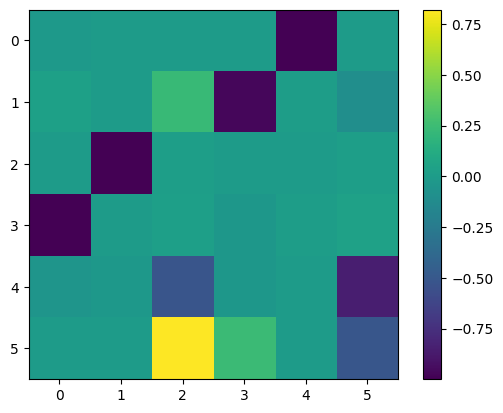

In [114]:
plt.imshow((Aopt))
plt.colorbar()

In [115]:
_lossfn = lambda a: lossfn_jac_jax(a, all_pars, all_fns, all_linear_pars, all_linear_inds, parts=True, X=X, Fs=Fs, n_params=n_params)

_lossfn(Aopt), _lossfn(np.eye(6))

((Array(13.061319, dtype=float32),
  Array(0.01378958, dtype=float32),
  Array(48.58535, dtype=float32)),
 (Array(11.932631, dtype=float32),
  Array(0.01668031, dtype=float32),
  Array(158.40547, dtype=float32)))

In [116]:
all_linear_pars, mdl_coordinates

([array([-0.60744 ,  0.998977, -0.232967,  0.434294, -0.100918,  0.265574]),
  array([ 1.000000e-06,  1.000001e+00,  3.836590e-01, -7.572200e-01,
         -7.866140e-01, -1.163720e-01,  1.061594e+00]),
  array([-1.313875,  1.003488,  0.755763]),
  array([-0.      ,  0.999961, -2.478776,  0.329284]),
  array([ 0.      ,  1.      , -0.052825, -0.417024, -0.634089, -1.102522,
          0.099662,  0.608666]),
  array([ 0.      ,  1.      ,  0.588514, -0.448049, -0.51236 , -0.306685,
          0.629234])],
 ['((-0.607440) + (0.998977 * (((((-0.232967) * X5) + (((0.434294 * X6) + sqrt(((0.122733 * X4) + (0.020625 * X6)))) + ((-0.100918) * X1))) + (0.265574 * X2)) + sqrt((0.066680 * X3)))))',
  '(0.000001 + (1.000001 * (((0.383659 * X5) + ((((-0.757220) * X2) + exp(((0.122923 * X6) + exp(((-1.414600) * X4))))) * ((-0.786614) + ((-0.116372) * X3)))) + 1.061594)))',
  '((-1.313875) + (1.003488 * ((sqrt((0.198412 * X3)) + ((((((-0.012877) * X1) + (0.022446 * X2)) + (0.083912 * X6)) + ((0.000745 

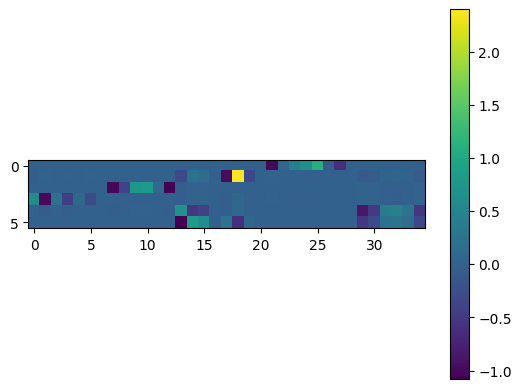

In [117]:
plt.imshow((Aopt @ construct_M(all_linear_pars, n_params=6)))
plt.colorbar()

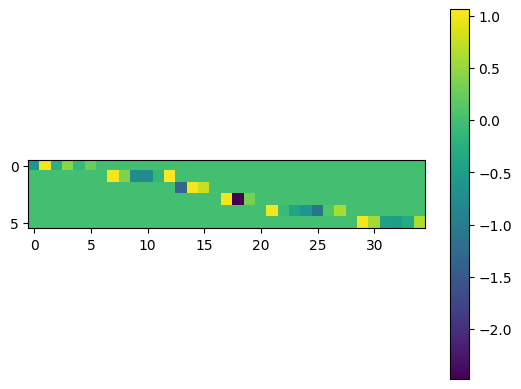

In [118]:
plt.imshow(construct_M(all_linear_pars, n_params=6))
plt.colorbar()

In [120]:
get_pruned_expressions(np.eye(6), 
                      all_param_dicts,
                       all_pars, all_linear_pars, all_expr, all_linear_labels, remove_floats=False, threshold=1e-20, n_params=n_params
                       )


(['-0.101*X1 + 0.265*X2 + 0.258*X3**0.5 - 0.233*X5 + 0.434*X6 + 0.35*(X4 + 0.168*X6)**0.5 - 0.607',
  '0.384*X5 + 1.0e-6*(757.0*X2 - 1000.0*exp(0.001*(123.0*X6*exp(1.415*X4) + 1000.0)*exp(-1.415*X4)))*(116.0*X3 + 787.0) + 1.062',
  '0.447*X3**0.5 + 0.758*X5 + 1.003*(-0.013*X1 + 0.022*X2 + 0.084*X6 + (0.001*X4)**(0.08*X4))**2 - 1.314',
  '1.0*2.576**(0.11*X3 + 0.042*X5 + exp(-1.902*X4)) + 0.329*X2 - 2.479 + 1.0*exp(-1.044*X3)',
  '0.001*(-1103.0*X4 + (-53.0*X1 - 417.0*X2 + 100.0*X5 - 634.0*X6 + 609.0)*exp(2.763*X4))*exp(-2.763*X4)',
  '0.001*((629.0*X2 + 519.0*sqrt(X3) - 307.0*X5 - 448.0*X6 - 512.0)*exp(2.331*X4) + 589.0)*exp(-2.331*X4)'],
 [[-0.101, 0.265, 0.258, 0.5, 0.233, 0.434, 0.35, 0.168, 0.5, 0.607],
  [0.384,
   1e-06,
   757.0,
   1000.0,
   0.001,
   123.0,
   1.415,
   1000.0,
   -1.415,
   116.0,
   787.0,
   1.062],
  [0.447, 0.5, 0.758, 1.003, -0.013, 0.022, 0.084, 0.001, 0.08, 1.314],
  [1.0, 2.576, 0.11, 0.042, -1.902, 0.329, 2.479, 1.0, -1.044],
  [0.001, -1103.0, -53.

In [ ]:
sr_exprs_vanilla, _ = get_pruned_expressions_final(np.eye(6), 
                      all_param_dicts,
                       all_pars, all_linear_pars, 
                       all_expr, all_linear_labels, 
                       remove_floats=False, threshold=0.05, n_params=n_params, X=X, Fs=Fs
                       )

0it [00:00, ?it/s]

Looking at component 0
  delta: 0.000000
  zeroed component -> skip!
  delta: 0.092756
  delta: 0.387051
  delta: 16.442110


1it [00:16, 16.13s/it]

  delta: 0.303074
Looking at component 1
  delta: 0.000000
  zeroed component -> skip!
  delta: 0.521603
  delta: 1.633224
  delta: 13.401516
  delta: 0.387353


2it [00:34, 17.37s/it]

  delta: 0.000000
Looking at component 2
  delta: 0.000000
  zeroed component -> skip!


3it [00:41, 12.76s/it]

  delta: 7.994753
Looking at component 3
  delta: 0.000000
  zeroed component -> skip!
  delta: 0.000000


4it [00:51, 11.79s/it]

  delta: 0.458522
Looking at component 4
  delta: 0.000000
  zeroed component -> skip!
  delta: 1.614138
  delta: 0.166952
  delta: 4.410641
  delta: -0.022125
  delta: 0.010476


5it [01:11, 14.58s/it]

  delta: 0.010476
Looking at component 5
  delta: 0.000000
  zeroed component -> skip!
  delta: 0.141118
  delta: 0.536949
  delta: 0.010476
  delta: 0.248249


6it [01:26, 14.47s/it]

  delta: 1.353572


In [97]:
sr_exprs_vanilla

['-0.101*X1 + 0.265*X2 + 0.258*X3**0.5 - 0.233*X5 + 0.434*X6 + 0.35*(X4 + 0.168*X6)**0.5',
 '0.384*X5 + (0.757*X2 - 1.0*exp((0.123*X6*exp(1.415*X4) + 1)*exp(-1.415*X4)))*(0.116*X3 + 0.787)',
 '0.447*X3**0.5 + 0.758*X5 + 1.003*(-0.013*X1 + 0.022*X2 + 0.084*X6 + (0.001*X4)**(0.08*X4))**2',
 '1.0*2.576**(0.11*X3 + 0.042*X5 + exp(-1.902*X4)) + 0.329*X2 + 1.0*exp(-1.044*X3)',
 '-0.053*X1 - 0.417*X2 - 0.634*X6',
 '0.629*X2 + 0.519*X3**0.5 - 0.307*X5 - 0.448*X6 + 0.589*exp(-2.331*X4)']

In [83]:
sr_exprs_vanilla

['-0.101*X1 + 0.265*X2 + 0.258*X3**0.5 - 0.233*X5 + 0.434*X6 + 0.35*(X4 + 0.168*X6)**0.5',
 '0.384*X5 + (0.757*X2 - 1.0*exp((0.123*X6*exp(1.415*X4) + 1)*exp(-1.415*X4)))*(0.116*X3 + 0.787)',
 '0.447*X3**0.5 + 0.758*X5 + 1.003*(-0.013*X1 + 0.022*X2 + 0.084*X6 + (0.001*X4)**(0.08*X4))**2',
 '1.0*2.576**(0.11*X3 + 0.042*X5 + exp(-1.902*X4)) + 0.329*X2 + 1.0*exp(-1.044*X3)',
 '-0.053*X1 - 0.417*X2 - 0.634*X6',
 '0.629*X2 + 0.519*X3**0.5 - 0.307*X5 - 0.448*X6 + 0.589*exp(-2.331*X4)']

In [126]:
fit_exprs0, _ = get_pruned_expressions(Aopt, all_param_dicts,
            all_pars, all_linear_pars, all_expr, all_linear_labels, remove_floats=False, threshold=0.1, decimal=3, n_params=n_params)

In [127]:
fit_exprs0

['-0.417*X2 - 1.102*X4*exp(-2.763*X4) - 0.634*X6 + 0.608',
 '-0.968*2.576**(0.11*X3 + 0.042*X5 + exp(-1.902*X4)) + 0.309*X2 + 0.101*X3**0.5 + 0.039*X5 + 0.226*(-0.013*X1 + 0.022*X2 + 0.084*X6 + (0.001*X4)**(0.08*X4))**2 - 2.621 - 0.968*exp(-1.044*X3)',
 '0.383*X5 - (0.756*X2 + 1.0*exp((0.123*X6*exp(1.415*X4) + 1)*exp(-1.415*X4)))*(0.116*X3 + 0.786) + 1.061',
 '-0.1*X1 + 0.264*X2 - 0.257*X3**0.5 - 0.232*X5 + 0.432*X6 - 0.349*(X4 + 0.168*X6)**0.5 + 0.606',
 '0.454*X2 - 0.674*X3**0.5 - 0.014*X5 - 0.324*X6 - 0.524*(-0.013*X1 + 0.022*X2 + 0.084*X6 + (0.001*X4)**(0.08*X4))**2 + 0.317 + 0.425*exp(-2.331*X4)',
 '0.244*2.576**(0.11*X3 + 0.042*X5 + exp(-1.902*X4)) + 0.167*X2 + 0.1*X3**0.5 + 0.43*X5 - 0.119*X6 + 0.824*(-0.013*X1 + 0.022*X2 + 0.084*X6 + (0.001*X4)**(0.08*X4))**2 - 1.363 + 0.156*exp(-2.331*X4) + 0.244*exp(-1.044*X3)']

In [100]:
fit_exprs, _ = get_pruned_expressions_final(Aopt, all_param_dicts,
            all_pars, all_linear_pars, all_expr, all_linear_labels,
             remove_floats=False, threshold=0.05, n_params=n_params, X=X, Fs=Fs, update=False, verbose=True)

0it [00:00, ?it/s]

Looking at component 0
  delta: 0.000000
  delta: 4517.692871
  delta: -0.073011
  delta: 0.148202
  delta: 4.521780


1it [02:59, 179.05s/it]

  delta: 0.007094
Looking at component 1
  delta: 0.000000
  delta: 2837.795166
  delta: 1.365651
  delta: 0.342072
  delta: 1.036235
  delta: 0.128738


2it [06:26, 196.02s/it]

  delta: 0.007094
Looking at component 2
  delta: 0.000000
  delta: 386.697845


3it [07:43, 141.37s/it]

  delta: 24.136269
Looking at component 3
  delta: 0.000000
  delta: 38415.277344
  delta: 0.007094


4it [09:55, 137.88s/it]

  delta: 0.756604
Looking at component 4
  delta: 0.000000
  delta: 726070.437500
  delta: 0.320088
  delta: 0.175206
  delta: 4.983549
  delta: -0.008282
  delta: -0.041853


5it [13:26, 163.96s/it]

  delta: -0.041853
Looking at component 5
  delta: 0.000000
  delta: 6.204720
  delta: -0.105623
  delta: 0.098070
  delta: -0.105623
  delta: -0.189169


6it [17:25, 174.31s/it]

  delta: 0.417638


In [128]:
fit_exprs

['-0.01*2.576**(0.11*X3 + 0.042*X5 + exp(-1.902*X4)) - 0.053*X1 - 0.416992197493458*X2 - 0.002*X3**0.5 - 0.634*X6 - 0.004*(X4 + 0.168*X6)**0.5 + 0.01*(-0.013*X1 + 0.022*X2 + 0.084*X6 + (0.001*X4)**(0.08*X4))**2 - 5.15577626953125e-6*exp(0.123*X6 + exp(-1.415*X4)) - 0.01*exp(-1.044*X3)',
 '((-0.968*2.576**(((0.11*X3 + 0.042*X5)*exp(1.902*X4) + 1)*exp(-1.902*X4)) + 0.315*X2 + 0.058*X3**0.5 + 0.039*X5 - 0.004*X6 - (7.0e-6*X3 + 4.2e-5)*exp((0.123*X6*exp(1.415*X4) + 1)*exp(-1.415*X4)) + 0.012*(X4 + 0.168*X6)**0.5 + 0.226*(-0.013*X1 + 0.022*X2 + 0.084*X6 + (0.001*X4)**(0.08*X4))**2)*exp(1.044*X3) - 0.968)*exp(-1.044*X3)',
 '((0.009*2.576**(((0.11*X3 + 0.042*X5)*exp(1.902*X4) + 1)*exp(-1.902*X4)) + 0.021*X3**0.5 + 0.384*X5 - (0.756*X2 + 1.0*exp((0.123*X6*exp(1.415*X4) + 1)*exp(-1.415*X4)))*(0.116*X3 + 0.786) + 0.003*(X4 + 0.168*X6)**0.5 + 0.018*(-0.013*X1 + 0.022*X2 + 0.084*X6 + (0.001*X4)**(0.08*X4))**2)*exp(1.044*X3) + 0.009)*exp(-1.044*X3)',
 '((-0.033*2.576**(((0.11*X3 + 0.042*X5)*exp(1.9

In [129]:
check_flats = lambda c: check_flattening(c, X=X, Fs=Fs)

In [130]:
n_d = 1
mdl_flats, mdl_J = check_flats(mdl_coordinates)
frob_flats, frob_J = check_flats(frob_coordinates)

In [131]:
from copy import deepcopy
fit_exprs2 = deepcopy(fit_exprs)

# substitute in mdl coordinates for zero components
# fit_exprs2[1] ="0.0" 
# fit_exprs2[0] = "0.0"

fit_exprs2, mdl_coordinates

(['-0.01*2.576**(0.11*X3 + 0.042*X5 + exp(-1.902*X4)) - 0.053*X1 - 0.416992197493458*X2 - 0.002*X3**0.5 - 0.634*X6 - 0.004*(X4 + 0.168*X6)**0.5 + 0.01*(-0.013*X1 + 0.022*X2 + 0.084*X6 + (0.001*X4)**(0.08*X4))**2 - 5.15577626953125e-6*exp(0.123*X6 + exp(-1.415*X4)) - 0.01*exp(-1.044*X3)',
  '((-0.968*2.576**(((0.11*X3 + 0.042*X5)*exp(1.902*X4) + 1)*exp(-1.902*X4)) + 0.315*X2 + 0.058*X3**0.5 + 0.039*X5 - 0.004*X6 - (7.0e-6*X3 + 4.2e-5)*exp((0.123*X6*exp(1.415*X4) + 1)*exp(-1.415*X4)) + 0.012*(X4 + 0.168*X6)**0.5 + 0.226*(-0.013*X1 + 0.022*X2 + 0.084*X6 + (0.001*X4)**(0.08*X4))**2)*exp(1.044*X3) - 0.968)*exp(-1.044*X3)',
  '((0.009*2.576**(((0.11*X3 + 0.042*X5)*exp(1.902*X4) + 1)*exp(-1.902*X4)) + 0.021*X3**0.5 + 0.384*X5 - (0.756*X2 + 1.0*exp((0.123*X6*exp(1.415*X4) + 1)*exp(-1.415*X4)))*(0.116*X3 + 0.786) + 0.003*(X4 + 0.168*X6)**0.5 + 0.018*(-0.013*X1 + 0.022*X2 + 0.084*X6 + (0.001*X4)**(0.08*X4))**2)*exp(1.044*X3) + 0.009)*exp(-1.044*X3)',
  '((-0.033*2.576**(((0.11*X3 + 0.042*X5)*exp

In [132]:
n_d = 1
fit_expr_flats0, _ = check_flats(fit_exprs0)
sr_expr_flats, _ = check_flats(sr_exprs_vanilla)

fit_expr_flats, _ = check_flats(fit_exprs)


In [133]:
jax.vmap(norm)(sr_expr_flats - jnp.eye(6)).mean()

Array(1.0502101, dtype=float32)

In [134]:
jax.vmap(norm)(fit_expr_flats0 - jnp.eye(6)).mean()

Array(4.5594077, dtype=float32)

In [135]:
jax.vmap(norm)(fit_expr_flats - jnp.eye(6)).mean()

Array(3.1812127, dtype=float32)

In [136]:
jax.vmap(norm)(mdl_flats - jnp.eye(6)).mean()

Array(1.0411414, dtype=float32)

In [137]:
jax.vmap(norm)(sr_expr_flats - jnp.eye(6)).mean()

Array(1.0502101, dtype=float32)

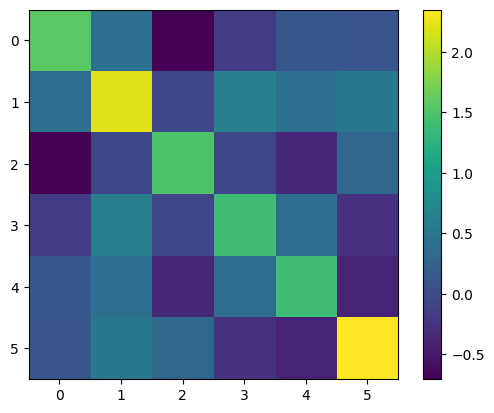

In [138]:
plt.imshow(fit_expr_flats.mean(0))
plt.colorbar()

In [139]:
mdl_flats = jax.vmap(flatten_with_numerical_jacobian)(mdl_J, Fs)
frob_flats = jax.vmap(flatten_with_numerical_jacobian)(frob_J, Fs)

In [140]:
mdl_flats.mean(0), frob_flats.mean(0)

(Array([[ 1.1861678 ,  0.22544731, -0.00756455,  0.24092829,  0.13717589,
          0.08189078],
        [ 0.22544731,  1.1380591 , -0.02171627,  0.00167246,  0.18577836,
         -0.06713111],
        [-0.00756455, -0.02171627,  1.0318506 ,  0.01938117, -0.02176731,
          0.03553393],
        [ 0.24092829,  0.00167246,  0.01938117,  1.3822606 ,  0.20752773,
          0.00697459],
        [ 0.1371759 ,  0.18577836, -0.02176731,  0.20752773,  1.1503688 ,
          0.05172862],
        [ 0.08189078, -0.06713111,  0.03553393,  0.00697459,  0.05172862,
          1.0269115 ]], dtype=float32),
 Array([[ 1.1811593 ,  0.2366763 , -0.00716445,  0.22257395,  0.13568124,
          0.08052224],
        [ 0.2366763 ,  1.1416823 , -0.02072458,  0.0564961 ,  0.20125811,
         -0.06933067],
        [-0.00716445, -0.02072458,  1.0343758 ,  0.04381161, -0.02648599,
          0.03605978],
        [ 0.22257395,  0.0564961 ,  0.04381161,  1.2203501 ,  0.19167964,
          0.00819246],
        [ 0.1

In [141]:
#@title fisher code
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_fisher_ellipse(fisher_matrix, mean=None, ax=None, color='blue', 
                        alpha=1.0, linestyle='-',
                       label=""):
    """
    Plots a Fisher information matrix ellipse.

    Parameters:
        fisher_matrix (numpy.ndarray): Fisher information matrix.
        mean (numpy.ndarray, optional): Mean vector. Defaults to None, in which case the ellipse will be centered at (0, 0).
        ax (matplotlib.axes.Axes, optional): Axes to plot on. If not provided, a new figure will be created.
        color (str, optional): Color of the ellipse. Defaults to 'blue'.
        alpha (float, optional): Transparency of the ellipse. Defaults to 0.5.
        linestyle (str, optional): Linestyle of the ellipse. Defaults to '-'.

    Returns:
        matplotlib.axes.Axes: Axes object with the ellipse plotted.
    """
    if ax is None:
        _, ax = plt.subplots()

    # Invert the Fisher information matrix to get the covariance matrix
    covariance_matrix = np.linalg.inv(fisher_matrix)

    # Calculate eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # Calculate ellipse angle
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # If mean is provided, set the center of the ellipse accordingly
    if mean is not None:
        center = mean
    else:
        center = np.zeros_like(covariance_matrix.shape[0])

    # Create ellipse for 1-sigma contour
    ellipse = Ellipse(xy=center,
                      width=2 * np.sqrt(eigenvalues[0]),
                      height=2 * np.sqrt(eigenvalues[1]),
                      angle=angle,
                      edgecolor=color,
                      linestyle=linestyle,
                      facecolor='none',
                      alpha=alpha,
                      label=label)

    # Create ellipse for 2-sigma contour
    ellipse2 = Ellipse(xy=center,
                       width=2 * 2 * np.sqrt(eigenvalues[0]),
                       height=2 * 2 * np.sqrt(eigenvalues[1]),
                       angle=angle,
                       edgecolor=color,
                       linestyle=linestyle,
                       facecolor='none',
                       alpha=alpha)

    ax.add_patch(ellipse)
    ax.add_patch(ellipse2)
    #ax.set_aspect('equal', 'box')
    ax.autoscale()
    return ax

In [142]:
#nn_flats = jax.vmap(jax.vmap(flatten_with_numerical_jacobian))(dys, ensemble_Fs).mean(0)

nn_flats = jax.vmap(flatten_with_numerical_jacobian)(dy, Fs)

In [143]:
Fs, dy

(array([[[ 1.27920574e-02, -3.42082717e-02, -1.13004481e-03,
          -4.90475111e-02, -6.58291811e-03, -5.28474711e-03],
         [-3.42082717e-02,  1.37877488e+00,  4.75072861e-02,
           7.31811896e-02,  1.80283590e-04,  4.97958027e-02],
         [-1.13004481e-03,  4.75072861e-02,  2.72833169e-01,
          -1.42118990e-01, -1.82714183e-02,  1.83415494e-03],
         [-4.90475111e-02,  7.31811896e-02, -1.42118990e-01,
           3.01991749e+01,  1.41651481e-02, -2.93586683e-02],
         [-6.58291811e-03,  1.80283590e-04, -1.82714183e-02,
           1.41651481e-02,  9.69208717e-01, -1.83330458e-02],
         [-5.28474711e-03,  4.97958027e-02,  1.83415494e-03,
          -2.93586683e-02, -1.83330458e-02,  9.56690907e-01]],
 
        [[ 1.31420046e-02, -3.21872234e-02, -6.31421525e-03,
          -7.12909084e-03, -9.87916719e-04, -6.00713119e-03],
         [-3.21872234e-02,  1.30011678e+00,  4.39455844e-02,
           1.14235699e-01,  1.47403369e-03,  1.93124022e-02],
         [-6.

In [144]:
nn_flats = jax.vmap(flatten_with_numerical_jacobian)(dy, Fs)
nn_flats.mean(0)

Array([[ 1.0705967 ,  0.02923882,  0.0164151 ,  0.02902345,  0.03165403,
        -0.00639825],
       [ 0.02923883,  1.0532969 , -0.02651536, -0.00620847,  0.00335143,
         0.00226884],
       [ 0.0164151 , -0.02651536,  1.068052  ,  0.04488024,  0.01248531,
        -0.01802492],
       [ 0.02902345, -0.00620847,  0.04488024,  1.0615776 ,  0.02018866,
        -0.03641403],
       [ 0.03165404,  0.00335143,  0.01248531,  0.02018866,  1.0410988 ,
        -0.0148805 ],
       [-0.00639825,  0.00226884, -0.01802492, -0.03641403, -0.0148805 ,
         1.0637051 ]], dtype=float32)

In [145]:
from preprocessing_utils import get_eigenvalues as get_evalues
evalues_nn = jax.vmap(get_evalues)(nn_flats)
evalues_mdl = jax.vmap(get_evalues)(mdl_flats)
evalues_frob = jax.vmap(get_evalues)(frob_flats)

evalues_fitexpr = jax.vmap(get_evalues)(fit_expr_flats0)

In [146]:
evalues_fitexpr

Array([[0.53845596, 0.7730638 , 1.2480247 , 1.6424087 , 2.8284326 ,
        4.267084  ],
       [0.5866782 , 0.70786285, 1.104187  , 1.9180717 , 2.9222467 ,
        4.0260935 ],
       [0.62209004, 0.7787592 , 1.2808204 , 1.7560714 , 2.7734044 ,
        5.4357142 ],
       ...,
       [0.70304716, 0.90634096, 1.4171673 , 2.119987  , 3.8477006 ,
        6.4124336 ],
       [0.6266449 , 0.8569981 , 1.1487423 , 2.3720536 , 3.3823216 ,
        4.52894   ],
       [0.6497743 , 0.74179226, 1.1135031 , 1.776384  , 2.7535083 ,
        4.28012   ]], dtype=float32)

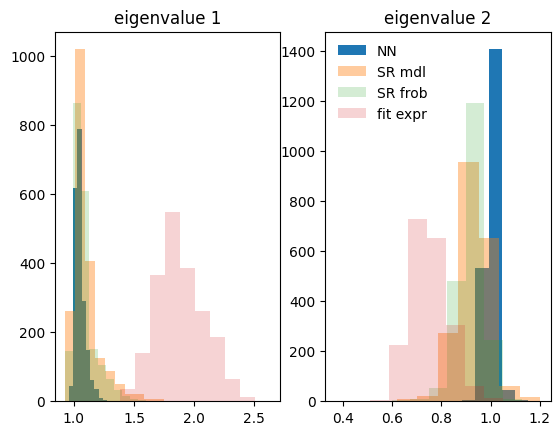

In [147]:
plt.subplot(121)
plt.title("eigenvalue 1")

plt.hist(evalues_nn[:, 3], label="NN")
plt.hist(evalues_mdl[:, 3], alpha=0.4, label="SR mdl")
plt.hist(evalues_frob[:, 3], alpha=0.2, label="SR frob")
plt.hist(evalues_fitexpr[:, 3], alpha=0.2, label="fit expr")


plt.subplot(122)
plt.title("eigenvalue 2")
plt.hist(evalues_nn[:, 1], label="NN")
plt.hist(evalues_mdl[:, 1], alpha=0.4, label="SR mdl")
plt.hist(evalues_frob[:, 1], alpha=0.2, label="SR frob")
plt.hist(evalues_fitexpr[:, 1], alpha=0.2, label="fit expr")


plt.legend(framealpha=0.0)

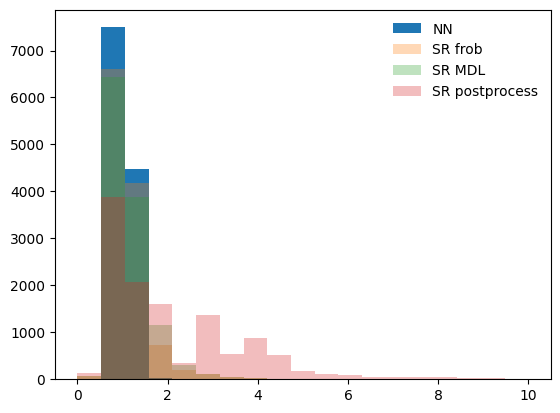

In [148]:
bins = np.linspace(0, 10, 20)
plt.hist(np.array(evalues_nn).flatten(), bins=bins, label='NN')
plt.hist(np.array(evalues_frob).flatten(), bins=bins, alpha=0.3, label='SR frob')
plt.hist(np.array(evalues_mdl).flatten(), bins=bins, alpha=0.3, label='SR MDL')
plt.hist(np.array(evalues_fitexpr).flatten(), bins=bins, alpha=0.3, label='SR postprocess')
plt.legend(framealpha=0.0)

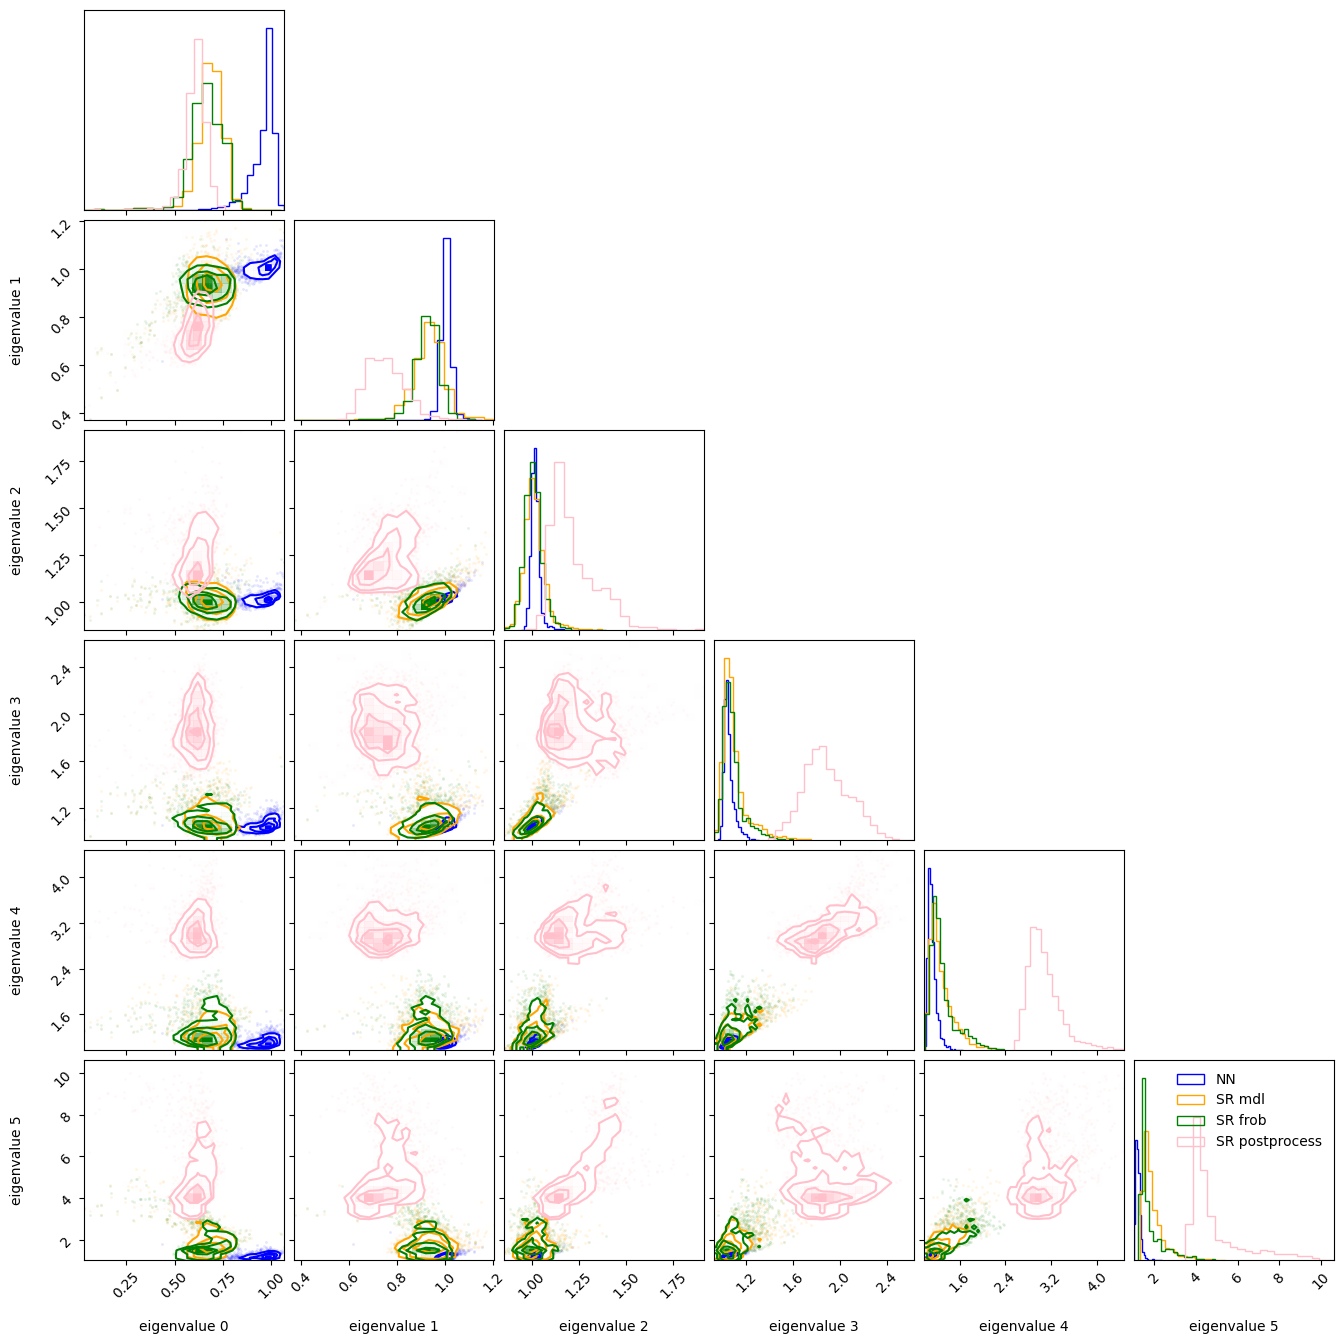

In [149]:
import corner

cols = ['eigenvalue %d'%(i) for i in range(6)]

figure = corner.corner(np.array(evalues_nn), color="blue", labels=cols, hist_kwargs=dict(label="NN"))
figure = corner.corner(np.array(evalues_mdl), color="orange", fig=figure, labels=cols, alpha=0.2, hist_kwargs=dict(label="SR mdl"))
figure = corner.corner(np.array(evalues_frob), color="green", fig=figure, labels=cols, alpha=0.2, hist_kwargs=dict(label="SR frob"))
figure = corner.corner(np.array(evalues_fitexpr), color="pink", fig=figure, labels=cols, alpha=0.2, hist_kwargs=dict(label="SR postprocess"))


plt.legend(framealpha=0.0)


In [98]:
nn_flats

Array([[[ 1.06527150e+00,  5.26751950e-02, -1.18930377e-02,
          2.78550684e-02,  4.50090170e-02, -9.64596495e-02],
        [ 5.26752472e-02,  1.02783823e+00, -3.39969993e-04,
          1.62329786e-02, -1.09068751e-02,  3.89025807e-02],
        [-1.18930414e-02, -3.39984894e-04,  1.00400364e+00,
          1.30277276e-02,  1.83072835e-02, -1.09105170e-01],
        [ 2.78550684e-02,  1.62329599e-02,  1.30278021e-02,
          1.08099282e+00,  3.98291871e-02, -1.20936275e-01],
        [ 4.50089946e-02, -1.09068602e-02,  1.83072686e-02,
          3.98291834e-02,  1.07122743e+00, -2.68759429e-02],
        [-9.64596346e-02,  3.89025807e-02, -1.09105185e-01,
         -1.20936245e-01, -2.68759802e-02,  9.77767110e-01]],

       [[ 1.07626200e+00,  1.29403695e-02,  3.95081043e-02,
          4.65420187e-02,  7.38491118e-03, -1.42521402e-02],
        [ 1.29403472e-02,  1.02494991e+00,  2.66680419e-02,
          1.32650807e-02, -1.03746355e-02, -7.12788105e-03],
        [ 3.95081043e-02,  2.6

TypeError: arctan2() takes from 2 to 3 positional arguments but 6 were given

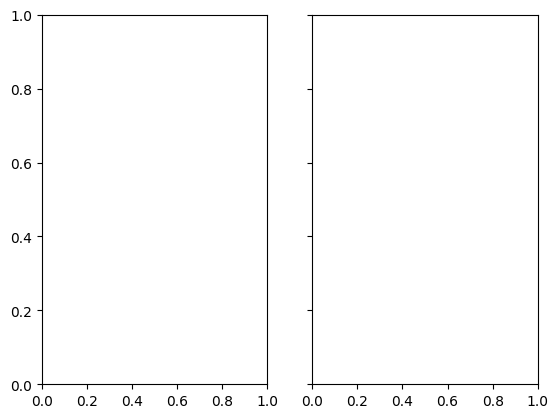

In [2209]:
# plot a smattering of fishers

randidx = np.random.choice(halfx, size=(12), replace=False)


_, axs = plt.subplots(1, 2, sharey=True) 


ax = axs[0]

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(nn_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(nn_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(2))



ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_title("NN flats")
ax.set_box_aspect(1)
ax = axs[1]

mdl_evalues = []

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(mdl_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
        
        plot_fisher_ellipse(mdl_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(frob_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
        
        plot_fisher_ellipse(frob_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(4))



ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_title("SR flats")

ax.set_box_aspect(1)


plt.legend()

#plt.tight_layout()

In [ ]:
datafile['norm_factor']

array(50.)

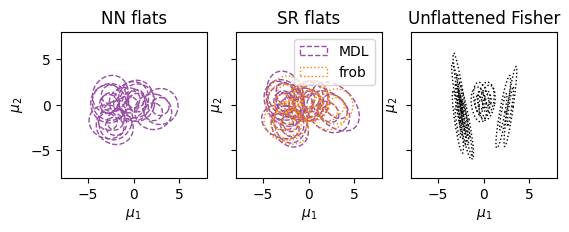

In [ ]:
# plot a smattering of fishers

randidx = np.random.choice(halfx, size=(12), replace=False)


_, axs = plt.subplots(1, 3, sharey=True)


ax = axs[0]

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(nn_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(nn_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(2))



ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_title("NN flats")
ax.set_box_aspect(1)
ax = axs[1]

mdl_evalues = []

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(mdl_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
        
        plot_fisher_ellipse(mdl_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(frob_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
        
        plot_fisher_ellipse(frob_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(4))

ax.legend()

ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_title("SR flats")


ax.set_box_aspect(1)




ax = axs[2]

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(Fs[r]*50,ax=ax, mean=X[r], color='k', linestyle=':')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(Fs[r]*datafile['norm_factor'] / 10., mean=X[r], ax=ax, label=labels[1], linestyle=':', color='k')
        #plot_fisher_ellipse(score_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(2))



ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_title("Unflattened Fisher")
ax.set_box_aspect(1)



#plt.tight_layout()

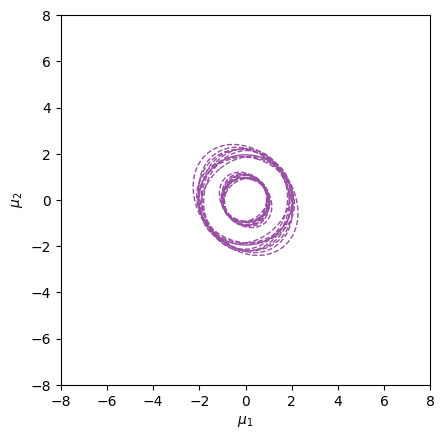

In [ ]:
# plot a smattering of fishers

randidx = np.random.choice(1000, size=(10), replace=False)


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(mdl_flats[r], mean=np.array([0, 0]), color=cm(3))

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(mdl_flats[r], mean=np.array([0, 0]), ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=np.array([0, 0]), ax=ax, label=labels[1], linestyle=':', color=cm(2))

ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-8,8)
ax.set_ylim(-8, 8)
ax.set_box_aspect(1)
#plt.legend()

In [ ]:
Fs * 50

array([[[ 57.03193  ,  10.4556055],
        [ 10.4556055,  17.953815 ]],

       [[436.8714   ,  75.04839  ],
        [ 75.04839  ,  14.848278 ]],

       [[380.1232   ,  72.68779  ],
        [ 72.68779  ,  16.019688 ]],

       ...,

       [[398.75772  ,  75.044304 ],
        [ 75.044304 ,  16.217165 ]],

       [[343.41068  , -60.79675  ],
        [-60.79675  ,  12.904592 ]],

       [[331.821    , -61.36552  ],
        [-61.36552  ,  13.351655 ]]], dtype=float32)

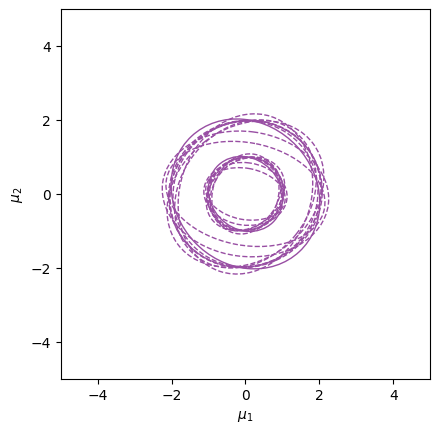

In [ ]:
# plot a smattering of fishers

randidx = np.random.choice(1000, size=(10), replace=False)


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(frob_flats[r], mean=np.array([0, 0]), color=cm(3))

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(mdl_flats[r], mean=np.array([0, 0]), ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=np.array([0, 0]), ax=ax, label=labels[1], linestyle=':', color=cm(2))

ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_box_aspect(1)
#plt.legend()

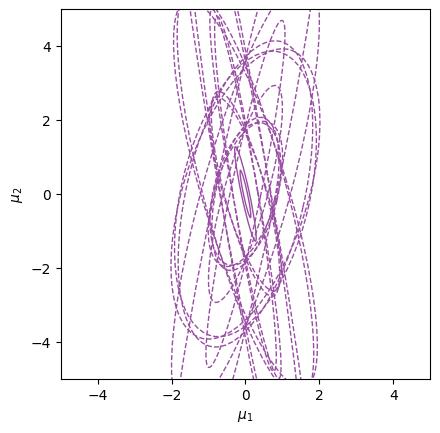

In [ ]:
# plot a smattering of fishers

#randidx = np.random.choice(1000, size=(10), replace=False)


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(Fs[r] * 50, mean=np.array([0, 0]), color=cm(3))

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(Fs[r], mean=np.array([0, 0]), ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=np.array([0, 0]), ax=ax, label=labels[1], linestyle=':', color=cm(2))

ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-5,5)
ax.set_ylim(-5, 5)
ax.set_box_aspect(1)
#plt.legend()